<a href="https://colab.research.google.com/github/therealsanthoshkumar/myrepositry/blob/main/Training%20Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
MobileNetV2 Training Script for Kria KV260 Deployment
Updated with modern PyTorch quantization API (PyTorch 2.0+)

Implements best practices for edge AI deployment including:
- Post-Training Quantization (PTQ) - simpler and more compatible
- Model optimization for DPU
- ONNX export
- Comprehensive evaluation
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.models import MobileNet_V2_Weights
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Training configuration optimized for Kria KV260"""

    # Data settings
    DATA_DIR = "./data"  # Update this to your dataset path
    BATCH_SIZE = 32
    NUM_WORKERS = 4
    TRAIN_SPLIT = 0.8
    VAL_SPLIT = 0.1
    TEST_SPLIT = 0.1

    # Model settings - Kria KV260 optimization
    INPUT_SIZE = 224  # Standard MobileNetV2 input
    NUM_CLASSES = 2  # Binary classification (update for your use case)
    PRETRAINED = True

    # Training settings
    NUM_EPOCHS = 50
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 1e-4
    EARLY_STOPPING_PATIENCE = 7

    # Quantization settings for Kria KV260 DPU
    # Using Post-Training Quantization (PTQ) instead of QAT for better compatibility
    QUANTIZE = True

    # Export settings
    EXPORT_ONNX = True
    ONNX_OPSET = 11  # Compatible with most deployment tools

    # Output settings
    OUTPUT_DIR = "./outputs"
    CHECKPOINT_DIR = "./checkpoints"

    # Device
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================================
# DATA PREPARATION
# ============================================================================

def get_data_transforms():
    """
    Define data augmentation and normalization for MobileNetV2
    Uses ImageNet statistics for transfer learning
    """
    train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(Config.INPUT_SIZE),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    val_test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(Config.INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_test_transform

def prepare_dataloaders():
    """Prepare train, validation, and test dataloaders"""

    train_transform, val_test_transform = get_data_transforms()

    # Load full dataset
    full_dataset = datasets.ImageFolder(root=Config.DATA_DIR)

    # Calculate split sizes
    total_size = len(full_dataset)
    train_size = int(Config.TRAIN_SPLIT * total_size)
    val_size = int(Config.VAL_SPLIT * total_size)
    test_size = total_size - train_size - val_size

    # Split dataset
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Apply transforms
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_test_transform
    test_dataset.dataset.transform = val_test_transform

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        num_workers=Config.NUM_WORKERS,
        pin_memory=True if torch.cuda.is_available() else False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=Config.NUM_WORKERS,
        pin_memory=True if torch.cuda.is_available() else False
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=Config.NUM_WORKERS,
        pin_memory=True if torch.cuda.is_available() else False
    )

    print(f"Dataset splits - Train: {train_size}, Val: {val_size}, Test: {test_size}")
    print(f"Class names: {full_dataset.classes}")

    return train_loader, val_loader, test_loader, full_dataset.classes

# ============================================================================
# MODEL DEFINITION
# ============================================================================

def create_mobilenetv2_model(num_classes=Config.NUM_CLASSES, pretrained=Config.PRETRAINED):
    """
    Create MobileNetV2 model optimized for Kria KV260

    Key optimizations:
    - Uses pretrained weights for better convergence
    - Modifies classifier for custom number of classes
    - Adds dropout for regularization
    """
    if pretrained:
        model = models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
    else:
        model = models.mobilenet_v2(weights=None)

    # Modify the classifier for custom number of classes
    # MobileNetV2 has 1280 features before the classifier
    in_features = model.classifier[1].in_features

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features, num_classes)
    )

    return model

# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    pbar = tqdm(dataloader, desc="Training")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Update progress bar
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc, all_preds, all_labels

# ============================================================================
# POST-TRAINING QUANTIZATION (Simpler and more compatible than QAT)
# ============================================================================

def calibrate_model(model, dataloader, device, num_batches=100):
    """
    Calibrate model for quantization using sample data
    This is used for Post-Training Quantization (PTQ)
    """
    model.eval()
    with torch.no_grad():
        for i, (inputs, _) in enumerate(tqdm(dataloader, desc="Calibrating")):
            if i >= num_batches:
                break
            inputs = inputs.to(device)
            model(inputs)

def quantize_model_ptq(model, val_loader, device):
    """
    Apply Post-Training Quantization (PTQ)
    More reliable than QAT for deployment to Kria KV260
    """
    print("\n🔧 Applying Post-Training Quantization...")

    # Move model to CPU for quantization
    model = model.cpu()
    model.eval()

    # Set quantization configuration
    model.qconfig = torch.quantization.get_default_qconfig('fbgemm')

    # Prepare for quantization (inserts observers)
    model_prepared = torch.quantization.prepare(model, inplace=False)

    # Calibrate with representative data
    calibrate_model(model_prepared, val_loader, torch.device('cpu'), num_batches=50)

    # Convert to quantized model
    model_quantized = torch.quantization.convert(model_prepared, inplace=False)

    print("✓ Post-Training Quantization completed")

    return model_quantized

# ============================================================================
# MAIN TRAINING LOOP
# ============================================================================

def train_model():
    """Main training function with all best practices"""

    # Create output directories
    os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
    os.makedirs(Config.CHECKPOINT_DIR, exist_ok=True)

    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.backends.cudnn.deterministic = True

    print("="*70)
    print("MobileNetV2 Training for Kria KV260 Deployment")
    print("="*70)
    print(f"Device: {Config.DEVICE}")
    print(f"Quantization: {'PTQ (Post-Training)' if Config.QUANTIZE else 'Disabled'}")
    print("="*70)

    # Prepare data
    print("\nPreparing data...")
    train_loader, val_loader, test_loader, class_names = prepare_dataloaders()

    # Create model
    print("\nCreating model...")
    model = create_mobilenetv2_model(num_classes=Config.NUM_CLASSES)
    model = model.to(Config.DEVICE)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                          lr=Config.LEARNING_RATE,
                          weight_decay=Config.WEIGHT_DECAY)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )

    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_val_acc = 0.0
    early_stopping_counter = 0

    print("\n" + "="*70)
    print("Starting Training...")
    print("="*70 + "\n")

    # Training loop
    for epoch in range(Config.NUM_EPOCHS):
        print(f"\nEpoch {epoch + 1}/{Config.NUM_EPOCHS}")
        print("-" * 50)

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, Config.DEVICE)

        # Validate
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, Config.DEVICE)

        # Update scheduler
        scheduler.step(val_loss)

        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print epoch results
        print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stopping_counter = 0
            checkpoint_path = os.path.join(Config.CHECKPOINT_DIR, 'best_model.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss,
            }, checkpoint_path)
            print(f"✓ Best model saved (Val Acc: {val_acc:.4f})")
        else:
            early_stopping_counter += 1

        # Early stopping
        if early_stopping_counter >= Config.EARLY_STOPPING_PATIENCE:
            print(f"\n⚠ Early stopping triggered after {epoch + 1} epochs")
            break

    print("\n" + "="*70)
    print("Training Completed!")
    print("="*70)

    # Load best model
    print("\nLoading best model...")
    checkpoint = torch.load(os.path.join(Config.CHECKPOINT_DIR, 'best_model.pth'))
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✓ Best model loaded (Val Acc: {checkpoint['val_acc']:.4f})")

    # Apply quantization if enabled
    model_quantized = None
    if Config.QUANTIZE:
        model_quantized = quantize_model_ptq(model, val_loader, Config.DEVICE)

    return model, model_quantized, history, class_names, test_loader

# ============================================================================
# EVALUATION
# ============================================================================

def evaluate_model(model, test_loader, class_names, model_name="Model"):
    """Comprehensive model evaluation"""

    print("\n" + "="*70)
    print(f"Evaluating {model_name} on Test Set...")
    print("="*70 + "\n")

    device = next(model.parameters()).device if hasattr(model, 'parameters') else torch.device('cpu')
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            # Handle quantized models (output may be different type)
            if isinstance(outputs, torch.Tensor):
                probs = torch.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, 1)
            else:
                # For quantized models, convert to tensor
                outputs_tensor = torch.from_numpy(outputs) if isinstance(outputs, np.ndarray) else outputs
                probs = torch.softmax(outputs_tensor, dim=1)
                _, preds = torch.max(outputs_tensor, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Print metrics
    print("\n📊 Test Set Metrics:")
    print("-" * 50)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    metrics = {
        'model': model_name,
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'confusion_matrix': conf_matrix.tolist(),
        'class_names': class_names
    }

    return metrics, conf_matrix

# ============================================================================
# MODEL EXPORT (for Kria KV260)
# ============================================================================

def export_model(model, model_quantized, class_names):
    """Export model for Kria KV260 deployment"""

    print("\n" + "="*70)
    print("Exporting Model for Deployment...")
    print("="*70 + "\n")

    model.eval()
    model = model.cpu()

    # 1. Save PyTorch model (FP32)
    pytorch_path = os.path.join(Config.OUTPUT_DIR, 'mobilenetv2_fp32.pth')
    torch.save(model.state_dict(), pytorch_path)
    print(f"✓ FP32 PyTorch model saved to {pytorch_path}")

    # 2. Save quantized model if available
    if model_quantized is not None:
        quant_path = os.path.join(Config.OUTPUT_DIR, 'mobilenetv2_int8.pth')
        torch.save(model_quantized.state_dict(), quant_path)
        print(f"✓ INT8 Quantized model saved to {quant_path}")

    # 3. Export to ONNX (for Vitis AI deployment on Kria)
    if Config.EXPORT_ONNX:
        dummy_input = torch.randn(1, 3, Config.INPUT_SIZE, Config.INPUT_SIZE)
        onnx_path = os.path.join(Config.OUTPUT_DIR, 'mobilenetv2_model.onnx')

        try:
            torch.onnx.export(
                model,
                dummy_input,
                onnx_path,
                export_params=True,
                opset_version=Config.ONNX_OPSET,
                do_constant_folding=True,
                input_names=['input'],
                output_names=['output'],
                dynamic_axes={
                    'input': {0: 'batch_size'},
                    'output': {0: 'batch_size'}
                }
            )
            print(f"✓ ONNX model saved to {onnx_path}")

            # Verify ONNX model
            try:
                import onnx
                onnx_model = onnx.load(onnx_path)
                onnx.checker.check_model(onnx_model)
                print("✓ ONNX model verification passed")
            except ImportError:
                print("⚠ ONNX not installed, skipping verification")
            except Exception as e:
                print(f"⚠ ONNX verification warning: {e}")
        except Exception as e:
            print(f"⚠ ONNX export failed: {e}")

    # 4. Save model metadata
    metadata = {
        'model_name': 'MobileNetV2',
        'input_size': Config.INPUT_SIZE,
        'num_classes': Config.NUM_CLASSES,
        'class_names': class_names,
        'quantized': Config.QUANTIZE,
        'quantization_type': 'PTQ' if Config.QUANTIZE else 'None',
        'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'preprocessing': {
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225]
        },
        'framework': 'PyTorch',
        'pytorch_version': torch.__version__
    }

    metadata_path = os.path.join(Config.OUTPUT_DIR, 'model_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)
    print(f"✓ Model metadata saved to {metadata_path}")

    # 5. Create deployment guide
    deployment_guide = f"""
# MobileNetV2 Deployment Guide for Kria KV260

## Model Information
- Architecture: MobileNetV2
- Input Size: {Config.INPUT_SIZE}x{Config.INPUT_SIZE}
- Number of Classes: {Config.NUM_CLASSES}
- Classes: {', '.join(class_names)}
- Quantization: {'PTQ (INT8)' if Config.QUANTIZE else 'FP32 only'}

## Files Generated
1. mobilenetv2_fp32.pth - PyTorch FP32 model weights
2. mobilenetv2_int8.pth - PyTorch INT8 quantized model (if enabled)
3. mobilenetv2_model.onnx - ONNX format for Vitis AI
4. model_metadata.json - Model configuration
5. test_metrics.json - Performance metrics

## Preprocessing Requirements
Images must be preprocessed with:
- Resize to 256x256
- Center crop to {Config.INPUT_SIZE}x{Config.INPUT_SIZE}
- Normalize with mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]

## Deployment Steps for Kria KV260

### Method 1: Using Vitis AI (Recommended)

#### Step 1: Quantize ONNX Model
```bash
# On development machine with Vitis AI Docker
./docker_run.sh xilinx/vitis-ai-pytorch:latest

# Inside container
vai_q_pytorch \\
  --model mobilenetv2_model.onnx \\
  --quant_mode calib \\
  --output_dir quantized/
```

#### Step 2: Compile for DPU
```bash
vai_c_xir \\
  --xmodel quantized/mobilenetv2_int.xmodel \\
  --arch /opt/vitis_ai/compiler/arch/DPUCZDX8G/KV260/arch.json \\
  --output_dir compiled/
```

#### Step 3: Deploy on Kria KV260
```python
import vart
import numpy as np
from PIL import Image

# Load DPU runner
dpu = vart.Runner.create_runner("mobilenetv2.xmodel", "run")

# Preprocess image
img = Image.open("test.jpg").resize(({Config.INPUT_SIZE}, {Config.INPUT_SIZE}))
img = np.array(img).astype(np.float32) / 255.0
img = (img - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
img = np.expand_dims(img.transpose(2, 0, 1), 0)

# Run inference
output = dpu.execute_async([img])[0]
prediction = np.argmax(output)
```

### Method 2: Using PyTorch on Kria (No DPU)

If deploying without DPU acceleration:

```python
import torch
from torchvision import transforms
from PIL import Image

# Load model
model = mobilenet_v2(num_classes={Config.NUM_CLASSES})
model.load_state_dict(torch.load('mobilenetv2_fp32.pth'))
model.eval()

# Preprocessing
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop({Config.INPUT_SIZE}),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Inference
img = Image.open("test.jpg")
input_tensor = transform(img).unsqueeze(0)
with torch.no_grad():
    output = model(input_tensor)
    prediction = output.argmax(1).item()
```

## Expected Performance

### FP32 Model
- Accuracy: See test_metrics_fp32.json
- CPU Inference: ~50-100ms per image
- Memory: ~14MB

### INT8 Quantized Model (with DPU)
- Accuracy: See test_metrics_int8.json (typically 0.5-1% drop from FP32)
- DPU Inference: ~15-30ms per image
- Throughput: ~30-60 FPS
- Memory: ~3.5MB

## Troubleshooting

### ONNX Export Issues
- Ensure PyTorch >= 2.0
- Try reducing opset version if needed
- Check for custom layers

### Quantization Accuracy Drop
- Increase calibration batches
- Use more representative calibration data
- Consider fine-tuning after quantization

### DPU Compilation Errors
- Verify arch.json matches your Kria version
- Check ONNX model compatibility
- Ensure all operations are DPU-supported

Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

    guide_path = os.path.join(Config.OUTPUT_DIR, 'DEPLOYMENT_GUIDE.md')
    with open(guide_path, 'w') as f:
        f.write(deployment_guide)
    print(f"✓ Deployment guide saved to {guide_path}")

# ============================================================================
# VISUALIZATION
# ============================================================================

def plot_training_history(history):
    """Plot training and validation metrics"""

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    axes[0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
    axes[0].plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # Plot accuracy
    axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o', linewidth=2)
    axes[1].plot(history['val_acc'], label='Val Accuracy', marker='s', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()

    plot_path = os.path.join(Config.OUTPUT_DIR, 'training_history.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"✓ Training history plot saved to {plot_path}")
    plt.close()

def plot_confusion_matrix(conf_matrix, class_names, model_name="Model"):
    """Plot confusion matrix"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    filename = f'confusion_matrix_{model_name.lower().replace(" ", "_")}.png'
    cm_path = os.path.join(Config.OUTPUT_DIR, filename)
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    print(f"✓ Confusion matrix saved to {cm_path}")
    plt.close()

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main execution function"""

    try:
        # Train model
        model, model_quantized, history, class_names, test_loader = train_model()

        # Plot training history
        plot_training_history(history)

        # Evaluate FP32 model
        metrics_fp32, cm_fp32 = evaluate_model(model.to(Config.DEVICE), test_loader, class_names, "FP32 Model")
        plot_confusion_matrix(cm_fp32, class_names, "FP32 Model")

        # Save FP32 metrics
        with open(os.path.join(Config.OUTPUT_DIR, 'test_metrics_fp32.json'), 'w') as f:
            json.dump(metrics_fp32, f, indent=4)

        # Evaluate quantized model if available
        if model_quantized is not None:
            metrics_int8, cm_int8 = evaluate_model(model_quantized, test_loader, class_names, "INT8 Quantized")
            plot_confusion_matrix(cm_int8, class_names, "INT8 Quantized")

            # Save INT8 metrics
            with open(os.path.join(Config.OUTPUT_DIR, 'test_metrics_int8.json'), 'w') as f:
                json.dump(metrics_int8, f, indent=4)

            # Compare metrics
            print("\n" + "="*70)
            print("Model Comparison")
            print("="*70)
            print(f"FP32 Accuracy:  {metrics_fp32['accuracy']:.4f}")
            print(f"INT8 Accuracy:  {metrics_int8['accuracy']:.4f}")
            print(f"Accuracy Drop:  {(metrics_fp32['accuracy'] - metrics_int8['accuracy']):.4f}")
            print("="*70)

        # Export models
        export_model(model, model_quantized, class_names)

        print("\n" + "="*70)
        print("✓ Pipeline Completed Successfully!")
        print("="*70)
        print(f"\nAll outputs saved to: {Config.OUTPUT_DIR}")
        print(f"Model checkpoints saved to: {Config.CHECKPOINT_DIR}")
        print("\nNext steps:")
        print("1. Review test_metrics_*.json for model performance")
        print("2. Check DEPLOYMENT_GUIDE.md for Kria KV260 deployment")
        print("3. Use Vitis AI to compile the ONNX model for DPU")
        if model_quantized:
            print("4. Compare FP32 vs INT8 performance trade-offs")
        print("="*70 + "\n")

    except Exception as e:
        print(f"\n❌ Error occurred: {e}")
        import traceback
        traceback.print_exc()
        print("\nTroubleshooting tips:")
        print("- Check if DATA_DIR path is correct")
        print("- Verify dataset has at least 2 classes")
        print("- Ensure sufficient GPU memory (reduce BATCH_SIZE if needed)")
        print("- Check all required packages are installed")

if __name__ == "__main__":
    main()

MobileNetV2 Training for Kria KV260 Deployment
Device: cuda
Quantization: PTQ (Post-Training)

Preparing data...

❌ Error occurred: [Errno 2] No such file or directory: './data'

Troubleshooting tips:
- Check if DATA_DIR path is correct
- Verify dataset has at least 2 classes
- Ensure sufficient GPU memory (reduce BATCH_SIZE if needed)
- Check all required packages are installed


Traceback (most recent call last):
  File "/tmp/ipython-input-2860976906.py", line 763, in main
    model, model_quantized, history, class_names, test_loader = train_model()
                                                                ^^^^^^^^^^^^^
  File "/tmp/ipython-input-2860976906.py", line 320, in train_model
    train_loader, val_loader, test_loader, class_names = prepare_dataloaders()
                                                         ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2860976906.py", line 106, in prepare_dataloaders
    full_dataset = datasets.ImageFolder(root=Config.DATA_DIR)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torchvision/datasets/folder.py", line 328, in __init__
    super().__init__(
  File "/usr/local/lib/python3.12/dist-packages/torchvision/datasets/folder.py", line 149, in __init__
    classes, class_to_idx = self.find_classes(self.root)
                            ^^^^^^^^^

In [ ]:
"""
MobileNetV2 Training Script for Kria KV260 Deployment
Updated with modern PyTorch quantization API (PyTorch 2.0+)

Implements best practices for edge AI deployment including:
- Post-Training Quantization (PTQ) - simpler and more compatible
- Model optimization for DPU
- ONNX export
- Comprehensive evaluation
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.models import MobileNet_V2_Weights
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Training configuration optimized for Kria KV260"""

    # Data settings
    DATA_DIR = "./data"  # Update this to your dataset path
    BATCH_SIZE = 32
    NUM_WORKERS = 4
    TRAIN_SPLIT = 0.8
    VAL_SPLIT = 0.1
    TEST_SPLIT = 0.1

    # Model settings - Kria KV260 optimization
    INPUT_SIZE = 224  # Standard MobileNetV2 input
    NUM_CLASSES = 2  # Binary classification (update for your use case)
    PRETRAINED = True

    # Training settings
    NUM_EPOCHS = 50
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 1e-4
    EARLY_STOPPING_PATIENCE = 7

    # Quantization settings for Kria KV260 DPU
    # Using Post-Training Quantization (PTQ) instead of QAT for better compatibility
    QUANTIZE = True

    # Export settings
    EXPORT_ONNX = True
    ONNX_OPSET = 11  # Compatible with most deployment tools

    # Output settings
    OUTPUT_DIR = "./outputs"
    CHECKPOINT_DIR = "./checkpoints"

    # Device
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================================
# DATA PREPARATION
# ============================================================================

def get_data_transforms():
    """
    Define data augmentation and normalization for MobileNetV2
    Uses ImageNet statistics for transfer learning
    """
    train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(Config.INPUT_SIZE),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    val_test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(Config.INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_test_transform

def prepare_dataloaders():
    """Prepare train, validation, and test dataloaders"""

    train_transform, val_test_transform = get_data_transforms()

    # Load full dataset
    full_dataset = datasets.ImageFolder(root=Config.DATA_DIR)

    # Calculate split sizes
    total_size = len(full_dataset)
    train_size = int(Config.TRAIN_SPLIT * total_size)
    val_size = int(Config.VAL_SPLIT * total_size)
    test_size = total_size - train_size - val_size

    # Split dataset
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Apply transforms
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_test_transform
    test_dataset.dataset.transform = val_test_transform

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        num_workers=Config.NUM_WORKERS,
        pin_memory=True if torch.cuda.is_available() else False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=Config.NUM_WORKERS,
        pin_memory=True if torch.cuda.is_available() else False
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=Config.NUM_WORKERS,
        pin_memory=True if torch.cuda.is_available() else False
    )

    print(f"Dataset splits - Train: {train_size}, Val: {val_size}, Test: {test_size}")
    print(f"Class names: {full_dataset.classes}")

    return train_loader, val_loader, test_loader, full_dataset.classes

# ============================================================================
# MODEL DEFINITION
# ============================================================================

def create_mobilenetv2_model(num_classes=Config.NUM_CLASSES, pretrained=Config.PRETRAINED):
    """
    Create MobileNetV2 model optimized for Kria KV260

    Key optimizations:
    - Uses pretrained weights for better convergence
    - Modifies classifier for custom number of classes
    - Adds dropout for regularization
    """
    if pretrained:
        model = models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
    else:
        model = models.mobilenet_v2(weights=None)

    # Modify the classifier for custom number of classes
    # MobileNetV2 has 1280 features before the classifier
    in_features = model.classifier[1].in_features

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features, num_classes)
    )

    return model

# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    pbar = tqdm(dataloader, desc="Training")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Update progress bar
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc, all_preds, all_labels

# ============================================================================
# POST-TRAINING QUANTIZATION (Simpler and more compatible than QAT)
# ============================================================================

def calibrate_model(model, dataloader, device, num_batches=100):
    """
    Calibrate model for quantization using sample data
    This is used for Post-Training Quantization (PTQ)
    """
    model.eval()
    with torch.no_grad():
        for i, (inputs, _) in enumerate(tqdm(dataloader, desc="Calibrating")):
            if i >= num_batches:
                break
            inputs = inputs.to(device)
            model(inputs)

def quantize_model_ptq(model, val_loader, device):
    """
    Apply Post-Training Quantization (PTQ)
    More reliable than QAT for deployment to Kria KV260
    """
    print("\n🔧 Applying Post-Training Quantization...")

    # Move model to CPU for quantization
    model = model.cpu()
    model.eval()

    # Set quantization configuration
    model.qconfig = torch.quantization.get_default_qconfig('fbgemm')

    # Prepare for quantization (inserts observers)
    model_prepared = torch.quantization.prepare(model, inplace=False)

    # Calibrate with representative data
    calibrate_model(model_prepared, val_loader, torch.device('cpu'), num_batches=50)

    # Convert to quantized model
    model_quantized = torch.quantization.convert(model_prepared, inplace=False)

    print("✓ Post-Training Quantization completed")

    return model_quantized

# ============================================================================
# MAIN TRAINING LOOP
# ============================================================================

def train_model():
    """Main training function with all best practices"""

    # Create output directories
    os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
    os.makedirs(Config.CHECKPOINT_DIR, exist_ok=True)

    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.backends.cudnn.deterministic = True

    print("="*70)
    print("MobileNetV2 Training for Kria KV260 Deployment")
    print("="*70)
    print(f"Device: {Config.DEVICE}")
    print(f"Quantization: {'PTQ (Post-Training)' if Config.QUANTIZE else 'Disabled'}")
    print("="*70)

    # Prepare data
    print("\nPreparing data...")
    train_loader, val_loader, test_loader, class_names = prepare_dataloaders()

    # Create model
    print("\nCreating model...")
    model = create_mobilenetv2_model(num_classes=Config.NUM_CLASSES)
    model = model.to(Config.DEVICE)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                          lr=Config.LEARNING_RATE,
                          weight_decay=Config.WEIGHT_DECAY)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )

    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_val_acc = 0.0
    early_stopping_counter = 0

    print("\n" + "="*70)
    print("Starting Training...")
    print("="*70 + "\n")

    # Training loop
    for epoch in range(Config.NUM_EPOCHS):
        print(f"\nEpoch {epoch + 1}/{Config.NUM_EPOCHS}")
        print("-" * 50)

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, Config.DEVICE)

        # Validate
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, Config.DEVICE)

        # Update scheduler
        scheduler.step(val_loss)

        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print epoch results
        print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stopping_counter = 0
            checkpoint_path = os.path.join(Config.CHECKPOINT_DIR, 'best_model.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss,
            }, checkpoint_path)
            print(f"✓ Best model saved (Val Acc: {val_acc:.4f})")
        else:
            early_stopping_counter += 1

        # Early stopping
        if early_stopping_counter >= Config.EARLY_STOPPING_PATIENCE:
            print(f"\n⚠ Early stopping triggered after {epoch + 1} epochs")
            break

    print("\n" + "="*70)
    print("Training Completed!")
    print("="*70)

    # Load best model
    print("\nLoading best model...")
    checkpoint = torch.load(os.path.join(Config.CHECKPOINT_DIR, 'best_model.pth'))
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✓ Best model loaded (Val Acc: {checkpoint['val_acc']:.4f})")

    # Apply quantization if enabled
    model_quantized = None
    if Config.QUANTIZE:
        model_quantized = quantize_model_ptq(model, val_loader, Config.DEVICE)

    return model, model_quantized, history, class_names, test_loader

# ============================================================================
# EVALUATION
# ============================================================================

def evaluate_model(model, test_loader, class_names, model_name="Model"):
    """Comprehensive model evaluation"""

    print("\n" + "="*70)
    print(f"Evaluating {model_name} on Test Set...")
    print("="*70 + "\n")

    device = next(model.parameters()).device if hasattr(model, 'parameters') else torch.device('cpu')
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            # Handle quantized models (output may be different type)
            if isinstance(outputs, torch.Tensor):
                probs = torch.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, 1)
            else:
                # For quantized models, convert to tensor
                outputs_tensor = torch.from_numpy(outputs) if isinstance(outputs, np.ndarray) else outputs
                probs = torch.softmax(outputs_tensor, dim=1)
                _, preds = torch.max(outputs_tensor, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Print metrics
    print("\n📊 Test Set Metrics:")
    print("-" * 50)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    metrics = {
        'model': model_name,
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'confusion_matrix': conf_matrix.tolist(),
        'class_names': class_names
    }

    return metrics, conf_matrix

# ============================================================================
# MODEL EXPORT (for Kria KV260)
# ============================================================================

def export_model(model, model_quantized, class_names):
    """Export model for Kria KV260 deployment"""

    print("\n" + "="*70)
    print("Exporting Model for Deployment...")
    print("="*70 + "\n")

    model.eval()
    model = model.cpu()

    # 1. Save PyTorch model (FP32)
    pytorch_path = os.path.join(Config.OUTPUT_DIR, 'mobilenetv2_fp32.pth')
    torch.save(model.state_dict(), pytorch_path)
    print(f"✓ FP32 PyTorch model saved to {pytorch_path}")

    # 2. Save quantized model if available
    if model_quantized is not None:
        quant_path = os.path.join(Config.OUTPUT_DIR, 'mobilenetv2_int8.pth')
        torch.save(model_quantized.state_dict(), quant_path)
        print(f"✓ INT8 Quantized model saved to {quant_path}")

    # 3. Export to ONNX (for Vitis AI deployment on Kria)
    if Config.EXPORT_ONNX:
        dummy_input = torch.randn(1, 3, Config.INPUT_SIZE, Config.INPUT_SIZE)
        onnx_path = os.path.join(Config.OUTPUT_DIR, 'mobilenetv2_model.onnx')

        try:
            torch.onnx.export(
                model,
                dummy_input,
                onnx_path,
                export_params=True,
                opset_version=Config.ONNX_OPSET,
                do_constant_folding=True,
                input_names=['input'],
                output_names=['output'],
                dynamic_axes={
                    'input': {0: 'batch_size'},
                    'output': {0: 'batch_size'}
                }
            )
            print(f"✓ ONNX model saved to {onnx_path}")

            # Verify ONNX model
            try:
                import onnx
                onnx_model = onnx.load(onnx_path)
                onnx.checker.check_model(onnx_model)
                print("✓ ONNX model verification passed")
            except ImportError:
                print("⚠ ONNX not installed, skipping verification")
            except Exception as e:
                print(f"⚠ ONNX verification warning: {e}")
        except Exception as e:
            print(f"⚠ ONNX export failed: {e}")

    # 4. Save model metadata
    metadata = {
        'model_name': 'MobileNetV2',
        'input_size': Config.INPUT_SIZE,
        'num_classes': Config.NUM_CLASSES,
        'class_names': class_names,
        'quantized': Config.QUANTIZE,
        'quantization_type': 'PTQ' if Config.QUANTIZE else 'None',
        'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'preprocessing': {
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225]
        },
        'framework': 'PyTorch',
        'pytorch_version': torch.__version__
    }

    metadata_path = os.path.join(Config.OUTPUT_DIR, 'model_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)
    print(f"✓ Model metadata saved to {metadata_path}")

    # 5. Create deployment guide
    deployment_guide = f"""
# MobileNetV2 Deployment Guide for Kria KV260

## Model Information
- Architecture: MobileNetV2
- Input Size: {Config.INPUT_SIZE}x{Config.INPUT_SIZE}
- Number of Classes: {Config.NUM_CLASSES}
- Classes: {', '.join(class_names)}
- Quantization: {'PTQ (INT8)' if Config.QUANTIZE else 'FP32 only'}

## Files Generated
1. mobilenetv2_fp32.pth - PyTorch FP32 model weights
2. mobilenetv2_int8.pth - PyTorch INT8 quantized model (if enabled)
3. mobilenetv2_model.onnx - ONNX format for Vitis AI
4. model_metadata.json - Model configuration
5. test_metrics.json - Performance metrics

## Preprocessing Requirements
Images must be preprocessed with:
- Resize to 256x256
- Center crop to {Config.INPUT_SIZE}x{Config.INPUT_SIZE}
- Normalize with mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]

## Deployment Steps for Kria KV260

### Method 1: Using Vitis AI (Recommended)

#### Step 1: Quantize ONNX Model
```bash
# On development machine with Vitis AI Docker
./docker_run.sh xilinx/vitis-ai-pytorch:latest

# Inside container
vai_q_pytorch \\
  --model mobilenetv2_model.onnx \\
  --quant_mode calib \\
  --output_dir quantized/
```

#### Step 2: Compile for DPU
```bash
vai_c_xir \\
  --xmodel quantized/mobilenetv2_int.xmodel \\
  --arch /opt/vitis_ai/compiler/arch/DPUCZDX8G/KV260/arch.json \\
  --output_dir compiled/
```

#### Step 3: Deploy on Kria KV260
```python
import vart
import numpy as np
from PIL import Image

# Load DPU runner
dpu = vart.Runner.create_runner("mobilenetv2.xmodel", "run")

# Preprocess image
img = Image.open("test.jpg").resize(({Config.INPUT_SIZE}, {Config.INPUT_SIZE}))
img = np.array(img).astype(np.float32) / 255.0
img = (img - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
img = np.expand_dims(img.transpose(2, 0, 1), 0)

# Run inference
output = dpu.execute_async([img])[0]
prediction = np.argmax(output)
```

### Method 2: Using PyTorch on Kria (No DPU)

If deploying without DPU acceleration:

```python
import torch
from torchvision import transforms
from PIL import Image

# Load model
model = mobilenet_v2(num_classes={Config.NUM_CLASSES})
model.load_state_dict(torch.load('mobilenetv2_fp32.pth'))
model.eval()

# Preprocessing
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop({Config.INPUT_SIZE}),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Inference
img = Image.open("test.jpg")
input_tensor = transform(img).unsqueeze(0)
with torch.no_grad():
    output = model(input_tensor)
    prediction = output.argmax(1).item()
```

## Expected Performance

### FP32 Model
- Accuracy: See test_metrics_fp32.json
- CPU Inference: ~50-100ms per image
- Memory: ~14MB

### INT8 Quantized Model (with DPU)
- Accuracy: See test_metrics_int8.json (typically 0.5-1% drop from FP32)
- DPU Inference: ~15-30ms per image
- Throughput: ~30-60 FPS
- Memory: ~3.5MB

## Troubleshooting

### ONNX Export Issues
- Ensure PyTorch >= 2.0
- Try reducing opset version if needed
- Check for custom layers

### Quantization Accuracy Drop
- Increase calibration batches
- Use more representative calibration data
- Consider fine-tuning after quantization

### DPU Compilation Errors
- Verify arch.json matches your Kria version
- Check ONNX model compatibility
- Ensure all operations are DPU-supported

Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

    guide_path = os.path.join(Config.OUTPUT_DIR, 'DEPLOYMENT_GUIDE.md')
    with open(guide_path, 'w') as f:
        f.write(deployment_guide)
    print(f"✓ Deployment guide saved to {guide_path}")

# ============================================================================
# VISUALIZATION
# ============================================================================

def plot_training_history(history):
    """Plot training and validation metrics"""

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    axes[0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
    axes[0].plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # Plot accuracy
    axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o', linewidth=2)
    axes[1].plot(history['val_acc'], label='Val Accuracy', marker='s', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()

    plot_path = os.path.join(Config.OUTPUT_DIR, 'training_history.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"✓ Training history plot saved to {plot_path}")
    plt.close()

def plot_confusion_matrix(conf_matrix, class_names, model_name="Model"):
    """Plot confusion matrix"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    filename = f'confusion_matrix_{model_name.lower().replace(" ", "_")}.png'
    cm_path = os.path.join(Config.OUTPUT_DIR, filename)
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    print(f"✓ Confusion matrix saved to {cm_path}")
    plt.close()

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main execution function"""

    try:
        # Train model
        model, model_quantized, history, class_names, test_loader = train_model()

        # Plot training history
        plot_training_history(history)

        # Evaluate FP32 model
        metrics_fp32, cm_fp32 = evaluate_model(model.to(Config.DEVICE), test_loader, class_names, "FP32 Model")
        plot_confusion_matrix(cm_fp32, class_names, "FP32 Model")

        # Save FP32 metrics
        with open(os.path.join(Config.OUTPUT_DIR, 'test_metrics_fp32.json'), 'w') as f:
            json.dump(metrics_fp32, f, indent=4)

        # Evaluate quantized model if available
        if model_quantized is not None:
            metrics_int8, cm_int8 = evaluate_model(model_quantized, test_loader, class_names, "INT8 Quantized")
            plot_confusion_matrix(cm_int8, class_names, "INT8 Quantized")

            # Save INT8 metrics
            with open(os.path.join(Config.OUTPUT_DIR, 'test_metrics_int8.json'), 'w') as f:
                json.dump(metrics_int8, f, indent=4)

            # Compare metrics
            print("\n" + "="*70)
            print("Model Comparison")
            print("="*70)
            print(f"FP32 Accuracy:  {metrics_fp32['accuracy']:.4f}")
            print(f"INT8 Accuracy:  {metrics_int8['accuracy']:.4f}")
            print(f"Accuracy Drop:  {(metrics_fp32['accuracy'] - metrics_int8['accuracy']):.4f}")
            print("="*70)

        # Export models
        export_model(model, model_quantized, class_names)

        print("\n" + "="*70)
        print("✓ Pipeline Completed Successfully!")
        print("="*70)
        print(f"\nAll outputs saved to: {Config.OUTPUT_DIR}")
        print(f"Model checkpoints saved to: {Config.CHECKPOINT_DIR}")
        print("\nNext steps:")
        print("1. Review test_metrics_*.json for model performance")
        print("2. Check DEPLOYMENT_GUIDE.md for Kria KV260 deployment")
        print("3. Use Vitis AI to compile the ONNX model for DPU")
        if model_quantized:
            print("4. Compare FP32 vs INT8 performance trade-offs")
        print("="*70 + "\n")

    except Exception as e:
        print(f"\n❌ Error occurred: {e}")
        import traceback
        traceback.print_exc()
        print("\nTroubleshooting tips:")
        print("- Check if DATA_DIR path is correct")
        print("- Verify dataset has at least 2 classes")
        print("- Ensure sufficient GPU memory (reduce BATCH_SIZE if needed)")
        print("- Check all required packages are installed")

if __name__ == "__main__":
    main()

MobileNetV2 Training for Kria KV260 Deployment
Device: cuda
Quantization: PTQ (Post-Training)

Preparing data...

❌ Error occurred: [Errno 2] No such file or directory: './data'

Troubleshooting tips:
- Check if DATA_DIR path is correct
- Verify dataset has at least 2 classes
- Ensure sufficient GPU memory (reduce BATCH_SIZE if needed)
- Check all required packages are installed


Traceback (most recent call last):
  File "/tmp/ipython-input-2860976906.py", line 763, in main
    model, model_quantized, history, class_names, test_loader = train_model()
                                                                ^^^^^^^^^^^^^
  File "/tmp/ipython-input-2860976906.py", line 320, in train_model
    train_loader, val_loader, test_loader, class_names = prepare_dataloaders()
                                                         ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2860976906.py", line 106, in prepare_dataloaders
    full_dataset = datasets.ImageFolder(root=Config.DATA_DIR)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torchvision/datasets/folder.py", line 328, in __init__
    super().__init__(
  File "/usr/local/lib/python3.12/dist-packages/torchvision/datasets/folder.py", line 149, in __init__
    classes, class_to_idx = self.find_classes(self.root)
                            ^^^^^^^^^

In [ ]:
"""
MobileNetV2 Training Script for Kria KV260 Deployment
Updated with modern PyTorch quantization API (PyTorch 2.0+)

Implements best practices for edge AI deployment including:
- Post-Training Quantization (PTQ) - simpler and more compatible
- Model optimization for DPU
- ONNX export
- Comprehensive evaluation
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.models import MobileNet_V2_Weights
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Training configuration optimized for Kria KV260"""

    # Data settings
    DATA_DIR = "./data"  # Update this to your dataset path
    BATCH_SIZE = 32
    NUM_WORKERS = 4
    TRAIN_SPLIT = 0.8
    VAL_SPLIT = 0.1
    TEST_SPLIT = 0.1

    # Model settings - Kria KV260 optimization
    INPUT_SIZE = 224  # Standard MobileNetV2 input
    NUM_CLASSES = 2  # Binary classification (update for your use case)
    PRETRAINED = True

    # Training settings
    NUM_EPOCHS = 50
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 1e-4
    EARLY_STOPPING_PATIENCE = 7

    # Quantization settings for Kria KV260 DPU
    # Using Post-Training Quantization (PTQ) instead of QAT for better compatibility
    QUANTIZE = True

    # Export settings
    EXPORT_ONNX = True
    ONNX_OPSET = 11  # Compatible with most deployment tools

    # Output settings
    OUTPUT_DIR = "./outputs"
    CHECKPOINT_DIR = "./checkpoints"

    # Device
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================================
# DATA PREPARATION
# ============================================================================

def get_data_transforms():
    """
    Define data augmentation and normalization for MobileNetV2
    Uses ImageNet statistics for transfer learning
    """
    train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(Config.INPUT_SIZE),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    val_test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(Config.INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_test_transform

def prepare_dataloaders():
    """Prepare train, validation, and test dataloaders"""

    train_transform, val_test_transform = get_data_transforms()

    # Load full dataset
    full_dataset = datasets.ImageFolder(root=Config.DATA_DIR)

    # Calculate split sizes
    total_size = len(full_dataset)
    train_size = int(Config.TRAIN_SPLIT * total_size)
    val_size = int(Config.VAL_SPLIT * total_size)
    test_size = total_size - train_size - val_size

    # Split dataset
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Apply transforms
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_test_transform
    test_dataset.dataset.transform = val_test_transform

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        num_workers=Config.NUM_WORKERS,
        pin_memory=True if torch.cuda.is_available() else False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=Config.NUM_WORKERS,
        pin_memory=True if torch.cuda.is_available() else False
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=Config.NUM_WORKERS,
        pin_memory=True if torch.cuda.is_available() else False
    )

    print(f"Dataset splits - Train: {train_size}, Val: {val_size}, Test: {test_size}")
    print(f"Class names: {full_dataset.classes}")

    return train_loader, val_loader, test_loader, full_dataset.classes

# ============================================================================
# MODEL DEFINITION
# ============================================================================

def create_mobilenetv2_model(num_classes=Config.NUM_CLASSES, pretrained=Config.PRETRAINED):
    """
    Create MobileNetV2 model optimized for Kria KV260

    Key optimizations:
    - Uses pretrained weights for better convergence
    - Modifies classifier for custom number of classes
    - Adds dropout for regularization
    """
    if pretrained:
        model = models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
    else:
        model = models.mobilenet_v2(weights=None)

    # Modify the classifier for custom number of classes
    # MobileNetV2 has 1280 features before the classifier
    in_features = model.classifier[1].in_features

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features, num_classes)
    )

    return model

# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    pbar = tqdm(dataloader, desc="Training")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Update progress bar
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc, all_preds, all_labels

# ============================================================================
# POST-TRAINING QUANTIZATION (Simpler and more compatible than QAT)
# ============================================================================

def calibrate_model(model, dataloader, device, num_batches=100):
    """
    Calibrate model for quantization using sample data
    This is used for Post-Training Quantization (PTQ)
    """
    model.eval()
    with torch.no_grad():
        for i, (inputs, _) in enumerate(tqdm(dataloader, desc="Calibrating")):
            if i >= num_batches:
                break
            inputs = inputs.to(device)
            model(inputs)

def quantize_model_ptq(model, val_loader, device):
    """
    Apply Post-Training Quantization (PTQ)
    More reliable than QAT for deployment to Kria KV260
    """
    print("\n🔧 Applying Post-Training Quantization...")

    # Move model to CPU for quantization
    model = model.cpu()
    model.eval()

    # Set quantization configuration
    model.qconfig = torch.quantization.get_default_qconfig('fbgemm')

    # Prepare for quantization (inserts observers)
    model_prepared = torch.quantization.prepare(model, inplace=False)

    # Calibrate with representative data
    calibrate_model(model_prepared, val_loader, torch.device('cpu'), num_batches=50)

    # Convert to quantized model
    model_quantized = torch.quantization.convert(model_prepared, inplace=False)

    print("✓ Post-Training Quantization completed")

    return model_quantized

# ============================================================================
# MAIN TRAINING LOOP
# ============================================================================

def train_model():
    """Main training function with all best practices"""

    # Create output directories
    os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
    os.makedirs(Config.CHECKPOINT_DIR, exist_ok=True)

    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.backends.cudnn.deterministic = True

    print("="*70)
    print("MobileNetV2 Training for Kria KV260 Deployment")
    print("="*70)
    print(f"Device: {Config.DEVICE}")
    print(f"Quantization: {'PTQ (Post-Training)' if Config.QUANTIZE else 'Disabled'}")
    print("="*70)

    # Prepare data
    print("\nPreparing data...")
    train_loader, val_loader, test_loader, class_names = prepare_dataloaders()

    # Create model
    print("\nCreating model...")
    model = create_mobilenetv2_model(num_classes=Config.NUM_CLASSES)
    model = model.to(Config.DEVICE)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                          lr=Config.LEARNING_RATE,
                          weight_decay=Config.WEIGHT_DECAY)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )

    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_val_acc = 0.0
    early_stopping_counter = 0

    print("\n" + "="*70)
    print("Starting Training...")
    print("="*70 + "\n")

    # Training loop
    for epoch in range(Config.NUM_EPOCHS):
        print(f"\nEpoch {epoch + 1}/{Config.NUM_EPOCHS}")
        print("-" * 50)

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, Config.DEVICE)

        # Validate
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, Config.DEVICE)

        # Update scheduler
        scheduler.step(val_loss)

        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print epoch results
        print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stopping_counter = 0
            checkpoint_path = os.path.join(Config.CHECKPOINT_DIR, 'best_model.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss,
            }, checkpoint_path)
            print(f"✓ Best model saved (Val Acc: {val_acc:.4f})")
        else:
            early_stopping_counter += 1

        # Early stopping
        if early_stopping_counter >= Config.EARLY_STOPPING_PATIENCE:
            print(f"\n⚠ Early stopping triggered after {epoch + 1} epochs")
            break

    print("\n" + "="*70)
    print("Training Completed!")
    print("="*70)

    # Load best model
    print("\nLoading best model...")
    checkpoint = torch.load(os.path.join(Config.CHECKPOINT_DIR, 'best_model.pth'))
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✓ Best model loaded (Val Acc: {checkpoint['val_acc']:.4f})")

    # Apply quantization if enabled
    model_quantized = None
    if Config.QUANTIZE:
        model_quantized = quantize_model_ptq(model, val_loader, Config.DEVICE)

    return model, model_quantized, history, class_names, test_loader

# ============================================================================
# EVALUATION
# ============================================================================

def evaluate_model(model, test_loader, class_names, model_name="Model"):
    """Comprehensive model evaluation"""

    print("\n" + "="*70)
    print(f"Evaluating {model_name} on Test Set...")
    print("="*70 + "\n")

    device = next(model.parameters()).device if hasattr(model, 'parameters') else torch.device('cpu')
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            # Handle quantized models (output may be different type)
            if isinstance(outputs, torch.Tensor):
                probs = torch.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, 1)
            else:
                # For quantized models, convert to tensor
                outputs_tensor = torch.from_numpy(outputs) if isinstance(outputs, np.ndarray) else outputs
                probs = torch.softmax(outputs_tensor, dim=1)
                _, preds = torch.max(outputs_tensor, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Print metrics
    print("\n📊 Test Set Metrics:")
    print("-" * 50)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    metrics = {
        'model': model_name,
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'confusion_matrix': conf_matrix.tolist(),
        'class_names': class_names
    }

    return metrics, conf_matrix

# ============================================================================
# MODEL EXPORT (for Kria KV260)
# ============================================================================

def export_model(model, model_quantized, class_names):
    """Export model for Kria KV260 deployment"""

    print("\n" + "="*70)
    print("Exporting Model for Deployment...")
    print("="*70 + "\n")

    model.eval()
    model = model.cpu()

    # 1. Save PyTorch model (FP32)
    pytorch_path = os.path.join(Config.OUTPUT_DIR, 'mobilenetv2_fp32.pth')
    torch.save(model.state_dict(), pytorch_path)
    print(f"✓ FP32 PyTorch model saved to {pytorch_path}")

    # 2. Save quantized model if available
    if model_quantized is not None:
        quant_path = os.path.join(Config.OUTPUT_DIR, 'mobilenetv2_int8.pth')
        torch.save(model_quantized.state_dict(), quant_path)
        print(f"✓ INT8 Quantized model saved to {quant_path}")

    # 3. Export to ONNX (for Vitis AI deployment on Kria)
    if Config.EXPORT_ONNX:
        dummy_input = torch.randn(1, 3, Config.INPUT_SIZE, Config.INPUT_SIZE)
        onnx_path = os.path.join(Config.OUTPUT_DIR, 'mobilenetv2_model.onnx')

        try:
            torch.onnx.export(
                model,
                dummy_input,
                onnx_path,
                export_params=True,
                opset_version=Config.ONNX_OPSET,
                do_constant_folding=True,
                input_names=['input'],
                output_names=['output'],
                dynamic_axes={
                    'input': {0: 'batch_size'},
                    'output': {0: 'batch_size'}
                }
            )
            print(f"✓ ONNX model saved to {onnx_path}")

            # Verify ONNX model
            try:
                import onnx
                onnx_model = onnx.load(onnx_path)
                onnx.checker.check_model(onnx_model)
                print("✓ ONNX model verification passed")
            except ImportError:
                print("⚠ ONNX not installed, skipping verification")
            except Exception as e:
                print(f"⚠ ONNX verification warning: {e}")
        except Exception as e:
            print(f"⚠ ONNX export failed: {e}")

    # 4. Save model metadata
    metadata = {
        'model_name': 'MobileNetV2',
        'input_size': Config.INPUT_SIZE,
        'num_classes': Config.NUM_CLASSES,
        'class_names': class_names,
        'quantized': Config.QUANTIZE,
        'quantization_type': 'PTQ' if Config.QUANTIZE else 'None',
        'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'preprocessing': {
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225]
        },
        'framework': 'PyTorch',
        'pytorch_version': torch.__version__
    }

    metadata_path = os.path.join(Config.OUTPUT_DIR, 'model_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)
    print(f"✓ Model metadata saved to {metadata_path}")

    # 5. Create deployment guide
    deployment_guide = f"""
# MobileNetV2 Deployment Guide for Kria KV260

## Model Information
- Architecture: MobileNetV2
- Input Size: {Config.INPUT_SIZE}x{Config.INPUT_SIZE}
- Number of Classes: {Config.NUM_CLASSES}
- Classes: {', '.join(class_names)}
- Quantization: {'PTQ (INT8)' if Config.QUANTIZE else 'FP32 only'}

## Files Generated
1. mobilenetv2_fp32.pth - PyTorch FP32 model weights
2. mobilenetv2_int8.pth - PyTorch INT8 quantized model (if enabled)
3. mobilenetv2_model.onnx - ONNX format for Vitis AI
4. model_metadata.json - Model configuration
5. test_metrics.json - Performance metrics

## Preprocessing Requirements
Images must be preprocessed with:
- Resize to 256x256
- Center crop to {Config.INPUT_SIZE}x{Config.INPUT_SIZE}
- Normalize with mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]

## Deployment Steps for Kria KV260

### Method 1: Using Vitis AI (Recommended)

#### Step 1: Quantize ONNX Model
```bash
# On development machine with Vitis AI Docker
./docker_run.sh xilinx/vitis-ai-pytorch:latest

# Inside container
vai_q_pytorch \\
  --model mobilenetv2_model.onnx \\
  --quant_mode calib \\
  --output_dir quantized/
```

#### Step 2: Compile for DPU
```bash
vai_c_xir \\
  --xmodel quantized/mobilenetv2_int.xmodel \\
  --arch /opt/vitis_ai/compiler/arch/DPUCZDX8G/KV260/arch.json \\
  --output_dir compiled/
```

#### Step 3: Deploy on Kria KV260
```python
import vart
import numpy as np
from PIL import Image

# Load DPU runner
dpu = vart.Runner.create_runner("mobilenetv2.xmodel", "run")

# Preprocess image
img = Image.open("test.jpg").resize(({Config.INPUT_SIZE}, {Config.INPUT_SIZE}))
img = np.array(img).astype(np.float32) / 255.0
img = (img - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
img = np.expand_dims(img.transpose(2, 0, 1), 0)

# Run inference
output = dpu.execute_async([img])[0]
prediction = np.argmax(output)
```

### Method 2: Using PyTorch on Kria (No DPU)

If deploying without DPU acceleration:

```python
import torch
from torchvision import transforms
from PIL import Image

# Load model
model = mobilenet_v2(num_classes={Config.NUM_CLASSES})
model.load_state_dict(torch.load('mobilenetv2_fp32.pth'))
model.eval()

# Preprocessing
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop({Config.INPUT_SIZE}),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Inference
img = Image.open("test.jpg")
input_tensor = transform(img).unsqueeze(0)
with torch.no_grad():
    output = model(input_tensor)
    prediction = output.argmax(1).item()
```

## Expected Performance

### FP32 Model
- Accuracy: See test_metrics_fp32.json
- CPU Inference: ~50-100ms per image
- Memory: ~14MB

### INT8 Quantized Model (with DPU)
- Accuracy: See test_metrics_int8.json (typically 0.5-1% drop from FP32)
- DPU Inference: ~15-30ms per image
- Throughput: ~30-60 FPS
- Memory: ~3.5MB

## Troubleshooting

### ONNX Export Issues
- Ensure PyTorch >= 2.0
- Try reducing opset version if needed
- Check for custom layers

### Quantization Accuracy Drop
- Increase calibration batches
- Use more representative calibration data
- Consider fine-tuning after quantization

### DPU Compilation Errors
- Verify arch.json matches your Kria version
- Check ONNX model compatibility
- Ensure all operations are DPU-supported

Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

    guide_path = os.path.join(Config.OUTPUT_DIR, 'DEPLOYMENT_GUIDE.md')
    with open(guide_path, 'w') as f:
        f.write(deployment_guide)
    print(f"✓ Deployment guide saved to {guide_path}")

# ============================================================================
# VISUALIZATION
# ============================================================================

def plot_training_history(history):
    """Plot training and validation metrics"""

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    axes[0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
    axes[0].plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # Plot accuracy
    axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o', linewidth=2)
    axes[1].plot(history['val_acc'], label='Val Accuracy', marker='s', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()

    plot_path = os.path.join(Config.OUTPUT_DIR, 'training_history.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"✓ Training history plot saved to {plot_path}")
    plt.close()

def plot_confusion_matrix(conf_matrix, class_names, model_name="Model"):
    """Plot confusion matrix"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    filename = f'confusion_matrix_{model_name.lower().replace(" ", "_")}.png'
    cm_path = os.path.join(Config.OUTPUT_DIR, filename)
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    print(f"✓ Confusion matrix saved to {cm_path}")
    plt.close()

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main execution function"""

    try:
        # Train model
        model, model_quantized, history, class_names, test_loader = train_model()

        # Plot training history
        plot_training_history(history)

        # Evaluate FP32 model
        metrics_fp32, cm_fp32 = evaluate_model(model.to(Config.DEVICE), test_loader, class_names, "FP32 Model")
        plot_confusion_matrix(cm_fp32, class_names, "FP32 Model")

        # Save FP32 metrics
        with open(os.path.join(Config.OUTPUT_DIR, 'test_metrics_fp32.json'), 'w') as f:
            json.dump(metrics_fp32, f, indent=4)

        # Evaluate quantized model if available
        if model_quantized is not None:
            metrics_int8, cm_int8 = evaluate_model(model_quantized, test_loader, class_names, "INT8 Quantized")
            plot_confusion_matrix(cm_int8, class_names, "INT8 Quantized")

            # Save INT8 metrics
            with open(os.path.join(Config.OUTPUT_DIR, 'test_metrics_int8.json'), 'w') as f:
                json.dump(metrics_int8, f, indent=4)

            # Compare metrics
            print("\n" + "="*70)
            print("Model Comparison")
            print("="*70)
            print(f"FP32 Accuracy:  {metrics_fp32['accuracy']:.4f}")
            print(f"INT8 Accuracy:  {metrics_int8['accuracy']:.4f}")
            print(f"Accuracy Drop:  {(metrics_fp32['accuracy'] - metrics_int8['accuracy']):.4f}")
            print("="*70)

        # Export models
        export_model(model, model_quantized, class_names)

        print("\n" + "="*70)
        print("✓ Pipeline Completed Successfully!")
        print("="*70)
        print(f"\nAll outputs saved to: {Config.OUTPUT_DIR}")
        print(f"Model checkpoints saved to: {Config.CHECKPOINT_DIR}")
        print("\nNext steps:")
        print("1. Review test_metrics_*.json for model performance")
        print("2. Check DEPLOYMENT_GUIDE.md for Kria KV260 deployment")
        print("3. Use Vitis AI to compile the ONNX model for DPU")
        if model_quantized:
            print("4. Compare FP32 vs INT8 performance trade-offs")
        print("="*70 + "\n")

    except Exception as e:
        print(f"\n❌ Error occurred: {e}")
        import traceback
        traceback.print_exc()
        print("\nTroubleshooting tips:")
        print("- Check if DATA_DIR path is correct")
        print("- Verify dataset has at least 2 classes")
        print("- Ensure sufficient GPU memory (reduce BATCH_SIZE if needed)")
        print("- Check all required packages are installed")

if __name__ == "__main__":
    main()

MobileNetV2 Training for Kria KV260 Deployment
Device: cuda
Quantization: PTQ (Post-Training)

Preparing data...

❌ Error occurred: [Errno 2] No such file or directory: './data'

Troubleshooting tips:
- Check if DATA_DIR path is correct
- Verify dataset has at least 2 classes
- Ensure sufficient GPU memory (reduce BATCH_SIZE if needed)
- Check all required packages are installed


Traceback (most recent call last):
  File "/tmp/ipython-input-2860976906.py", line 763, in main
    model, model_quantized, history, class_names, test_loader = train_model()
                                                                ^^^^^^^^^^^^^
  File "/tmp/ipython-input-2860976906.py", line 320, in train_model
    train_loader, val_loader, test_loader, class_names = prepare_dataloaders()
                                                         ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2860976906.py", line 106, in prepare_dataloaders
    full_dataset = datasets.ImageFolder(root=Config.DATA_DIR)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torchvision/datasets/folder.py", line 328, in __init__
    super().__init__(
  File "/usr/local/lib/python3.12/dist-packages/torchvision/datasets/folder.py", line 149, in __init__
    classes, class_to_idx = self.find_classes(self.root)
                            ^^^^^^^^^

In [ ]:
"""
MobileNetV2 Training Script for Kria KV260 Deployment
Updated with modern PyTorch quantization API (PyTorch 2.0+)

Implements best practices for edge AI deployment including:
- Post-Training Quantization (PTQ) - simpler and more compatible
- Model optimization for DPU
- ONNX export
- Comprehensive evaluation
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.models import MobileNet_V2_Weights
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Training configuration optimized for Kria KV260"""

    # Data settings
    DATA_DIR = "./data"  # Update this to your dataset path
    BATCH_SIZE = 32
    NUM_WORKERS = 4
    TRAIN_SPLIT = 0.8
    VAL_SPLIT = 0.1
    TEST_SPLIT = 0.1

    # Model settings - Kria KV260 optimization
    INPUT_SIZE = 224  # Standard MobileNetV2 input
    NUM_CLASSES = 2  # Binary classification (update for your use case)
    PRETRAINED = True

    # Training settings
    NUM_EPOCHS = 50
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 1e-4
    EARLY_STOPPING_PATIENCE = 7

    # Quantization settings for Kria KV260 DPU
    # Using Post-Training Quantization (PTQ) instead of QAT for better compatibility
    QUANTIZE = True

    # Export settings
    EXPORT_ONNX = True
    ONNX_OPSET = 11  # Compatible with most deployment tools

    # Output settings
    OUTPUT_DIR = "./outputs"
    CHECKPOINT_DIR = "./checkpoints"

    # Device
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================================
# DATA PREPARATION
# ============================================================================

def get_data_transforms():
    """
    Define data augmentation and normalization for MobileNetV2
    Uses ImageNet statistics for transfer learning
    """
    train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(Config.INPUT_SIZE),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    val_test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(Config.INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_test_transform

def prepare_dataloaders():
    """Prepare train, validation, and test dataloaders"""

    train_transform, val_test_transform = get_data_transforms()

    # Load full dataset
    full_dataset = datasets.ImageFolder(root=Config.DATA_DIR)

    # Calculate split sizes
    total_size = len(full_dataset)
    train_size = int(Config.TRAIN_SPLIT * total_size)
    val_size = int(Config.VAL_SPLIT * total_size)
    test_size = total_size - train_size - val_size

    # Split dataset
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Apply transforms
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_test_transform
    test_dataset.dataset.transform = val_test_transform

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        num_workers=Config.NUM_WORKERS,
        pin_memory=True if torch.cuda.is_available() else False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=Config.NUM_WORKERS,
        pin_memory=True if torch.cuda.is_available() else False
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=Config.NUM_WORKERS,
        pin_memory=True if torch.cuda.is_available() else False
    )

    print(f"Dataset splits - Train: {train_size}, Val: {val_size}, Test: {test_size}")
    print(f"Class names: {full_dataset.classes}")

    return train_loader, val_loader, test_loader, full_dataset.classes

# ============================================================================
# MODEL DEFINITION
# ============================================================================

def create_mobilenetv2_model(num_classes=Config.NUM_CLASSES, pretrained=Config.PRETRAINED):
    """
    Create MobileNetV2 model optimized for Kria KV260

    Key optimizations:
    - Uses pretrained weights for better convergence
    - Modifies classifier for custom number of classes
    - Adds dropout for regularization
    """
    if pretrained:
        model = models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
    else:
        model = models.mobilenet_v2(weights=None)

    # Modify the classifier for custom number of classes
    # MobileNetV2 has 1280 features before the classifier
    in_features = model.classifier[1].in_features

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features, num_classes)
    )

    return model

# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    pbar = tqdm(dataloader, desc="Training")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Update progress bar
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc, all_preds, all_labels

# ============================================================================
# POST-TRAINING QUANTIZATION (Simpler and more compatible than QAT)
# ============================================================================

def calibrate_model(model, dataloader, device, num_batches=100):
    """
    Calibrate model for quantization using sample data
    This is used for Post-Training Quantization (PTQ)
    """
    model.eval()
    with torch.no_grad():
        for i, (inputs, _) in enumerate(tqdm(dataloader, desc="Calibrating")):
            if i >= num_batches:
                break
            inputs = inputs.to(device)
            model(inputs)

def quantize_model_ptq(model, val_loader, device):
    """
    Apply Post-Training Quantization (PTQ)
    More reliable than QAT for deployment to Kria KV260
    """
    print("\n🔧 Applying Post-Training Quantization...")

    # Move model to CPU for quantization
    model = model.cpu()
    model.eval()

    # Set quantization configuration
    model.qconfig = torch.quantization.get_default_qconfig('fbgemm')

    # Prepare for quantization (inserts observers)
    model_prepared = torch.quantization.prepare(model, inplace=False)

    # Calibrate with representative data
    calibrate_model(model_prepared, val_loader, torch.device('cpu'), num_batches=50)

    # Convert to quantized model
    model_quantized = torch.quantization.convert(model_prepared, inplace=False)

    print("✓ Post-Training Quantization completed")

    return model_quantized

# ============================================================================
# MAIN TRAINING LOOP
# ============================================================================

def train_model():
    """Main training function with all best practices"""

    # Create output directories
    os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
    os.makedirs(Config.CHECKPOINT_DIR, exist_ok=True)

    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.backends.cudnn.deterministic = True

    print("="*70)
    print("MobileNetV2 Training for Kria KV260 Deployment")
    print("="*70)
    print(f"Device: {Config.DEVICE}")
    print(f"Quantization: {'PTQ (Post-Training)' if Config.QUANTIZE else 'Disabled'}")
    print("="*70)

    # Prepare data
    print("\nPreparing data...")
    train_loader, val_loader, test_loader, class_names = prepare_dataloaders()

    # Create model
    print("\nCreating model...")
    model = create_mobilenetv2_model(num_classes=Config.NUM_CLASSES)
    model = model.to(Config.DEVICE)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                          lr=Config.LEARNING_RATE,
                          weight_decay=Config.WEIGHT_DECAY)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )

    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_val_acc = 0.0
    early_stopping_counter = 0

    print("\n" + "="*70)
    print("Starting Training...")
    print("="*70 + "\n")

    # Training loop
    for epoch in range(Config.NUM_EPOCHS):
        print(f"\nEpoch {epoch + 1}/{Config.NUM_EPOCHS}")
        print("-" * 50)

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, Config.DEVICE)

        # Validate
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, Config.DEVICE)

        # Update scheduler
        scheduler.step(val_loss)

        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print epoch results
        print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stopping_counter = 0
            checkpoint_path = os.path.join(Config.CHECKPOINT_DIR, 'best_model.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss,
            }, checkpoint_path)
            print(f"✓ Best model saved (Val Acc: {val_acc:.4f})")
        else:
            early_stopping_counter += 1

        # Early stopping
        if early_stopping_counter >= Config.EARLY_STOPPING_PATIENCE:
            print(f"\n⚠ Early stopping triggered after {epoch + 1} epochs")
            break

    print("\n" + "="*70)
    print("Training Completed!")
    print("="*70)

    # Load best model
    print("\nLoading best model...")
    checkpoint = torch.load(os.path.join(Config.CHECKPOINT_DIR, 'best_model.pth'))
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✓ Best model loaded (Val Acc: {checkpoint['val_acc']:.4f})")

    # Apply quantization if enabled
    model_quantized = None
    if Config.QUANTIZE:
        model_quantized = quantize_model_ptq(model, val_loader, Config.DEVICE)

    return model, model_quantized, history, class_names, test_loader

# ============================================================================
# EVALUATION
# ============================================================================

def evaluate_model(model, test_loader, class_names, model_name="Model"):
    """Comprehensive model evaluation"""

    print("\n" + "="*70)
    print(f"Evaluating {model_name} on Test Set...")
    print("="*70 + "\n")

    device = next(model.parameters()).device if hasattr(model, 'parameters') else torch.device('cpu')
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            # Handle quantized models (output may be different type)
            if isinstance(outputs, torch.Tensor):
                probs = torch.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, 1)
            else:
                # For quantized models, convert to tensor
                outputs_tensor = torch.from_numpy(outputs) if isinstance(outputs, np.ndarray) else outputs
                probs = torch.softmax(outputs_tensor, dim=1)
                _, preds = torch.max(outputs_tensor, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Print metrics
    print("\n📊 Test Set Metrics:")
    print("-" * 50)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    metrics = {
        'model': model_name,
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'confusion_matrix': conf_matrix.tolist(),
        'class_names': class_names
    }

    return metrics, conf_matrix

# ============================================================================
# MODEL EXPORT (for Kria KV260)
# ============================================================================

def export_model(model, model_quantized, class_names):
    """Export model for Kria KV260 deployment"""

    print("\n" + "="*70)
    print("Exporting Model for Deployment...")
    print("="*70 + "\n")

    model.eval()
    model = model.cpu()

    # 1. Save PyTorch model (FP32)
    pytorch_path = os.path.join(Config.OUTPUT_DIR, 'mobilenetv2_fp32.pth')
    torch.save(model.state_dict(), pytorch_path)
    print(f"✓ FP32 PyTorch model saved to {pytorch_path}")

    # 2. Save quantized model if available
    if model_quantized is not None:
        quant_path = os.path.join(Config.OUTPUT_DIR, 'mobilenetv2_int8.pth')
        torch.save(model_quantized.state_dict(), quant_path)
        print(f"✓ INT8 Quantized model saved to {quant_path}")

    # 3. Export to ONNX (for Vitis AI deployment on Kria)
    if Config.EXPORT_ONNX:
        dummy_input = torch.randn(1, 3, Config.INPUT_SIZE, Config.INPUT_SIZE)
        onnx_path = os.path.join(Config.OUTPUT_DIR, 'mobilenetv2_model.onnx')

        try:
            torch.onnx.export(
                model,
                dummy_input,
                onnx_path,
                export_params=True,
                opset_version=Config.ONNX_OPSET,
                do_constant_folding=True,
                input_names=['input'],
                output_names=['output'],
                dynamic_axes={
                    'input': {0: 'batch_size'},
                    'output': {0: 'batch_size'}
                }
            )
            print(f"✓ ONNX model saved to {onnx_path}")

            # Verify ONNX model
            try:
                import onnx
                onnx_model = onnx.load(onnx_path)
                onnx.checker.check_model(onnx_model)
                print("✓ ONNX model verification passed")
            except ImportError:
                print("⚠ ONNX not installed, skipping verification")
            except Exception as e:
                print(f"⚠ ONNX verification warning: {e}")
        except Exception as e:
            print(f"⚠ ONNX export failed: {e}")

    # 4. Save model metadata
    metadata = {
        'model_name': 'MobileNetV2',
        'input_size': Config.INPUT_SIZE,
        'num_classes': Config.NUM_CLASSES,
        'class_names': class_names,
        'quantized': Config.QUANTIZE,
        'quantization_type': 'PTQ' if Config.QUANTIZE else 'None',
        'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'preprocessing': {
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225]
        },
        'framework': 'PyTorch',
        'pytorch_version': torch.__version__
    }

    metadata_path = os.path.join(Config.OUTPUT_DIR, 'model_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)
    print(f"✓ Model metadata saved to {metadata_path}")

    # 5. Create deployment guide
    deployment_guide = f"""
# MobileNetV2 Deployment Guide for Kria KV260

## Model Information
- Architecture: MobileNetV2
- Input Size: {Config.INPUT_SIZE}x{Config.INPUT_SIZE}
- Number of Classes: {Config.NUM_CLASSES}
- Classes: {', '.join(class_names)}
- Quantization: {'PTQ (INT8)' if Config.QUANTIZE else 'FP32 only'}

## Files Generated
1. mobilenetv2_fp32.pth - PyTorch FP32 model weights
2. mobilenetv2_int8.pth - PyTorch INT8 quantized model (if enabled)
3. mobilenetv2_model.onnx - ONNX format for Vitis AI
4. model_metadata.json - Model configuration
5. test_metrics.json - Performance metrics

## Preprocessing Requirements
Images must be preprocessed with:
- Resize to 256x256
- Center crop to {Config.INPUT_SIZE}x{Config.INPUT_SIZE}
- Normalize with mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]

## Deployment Steps for Kria KV260

### Method 1: Using Vitis AI (Recommended)

#### Step 1: Quantize ONNX Model
```bash
# On development machine with Vitis AI Docker
./docker_run.sh xilinx/vitis-ai-pytorch:latest

# Inside container
vai_q_pytorch \\
  --model mobilenetv2_model.onnx \\
  --quant_mode calib \\
  --output_dir quantized/
```

#### Step 2: Compile for DPU
```bash
vai_c_xir \\
  --xmodel quantized/mobilenetv2_int.xmodel \\
  --arch /opt/vitis_ai/compiler/arch/DPUCZDX8G/KV260/arch.json \\
  --output_dir compiled/
```

#### Step 3: Deploy on Kria KV260
```python
import vart
import numpy as np
from PIL import Image

# Load DPU runner
dpu = vart.Runner.create_runner("mobilenetv2.xmodel", "run")

# Preprocess image
img = Image.open("test.jpg").resize(({Config.INPUT_SIZE}, {Config.INPUT_SIZE}))
img = np.array(img).astype(np.float32) / 255.0
img = (img - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
img = np.expand_dims(img.transpose(2, 0, 1), 0)

# Run inference
output = dpu.execute_async([img])[0]
prediction = np.argmax(output)
```

### Method 2: Using PyTorch on Kria (No DPU)

If deploying without DPU acceleration:

```python
import torch
from torchvision import transforms
from PIL import Image

# Load model
model = mobilenet_v2(num_classes={Config.NUM_CLASSES})
model.load_state_dict(torch.load('mobilenetv2_fp32.pth'))
model.eval()

# Preprocessing
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop({Config.INPUT_SIZE}),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Inference
img = Image.open("test.jpg")
input_tensor = transform(img).unsqueeze(0)
with torch.no_grad():
    output = model(input_tensor)
    prediction = output.argmax(1).item()
```

## Expected Performance

### FP32 Model
- Accuracy: See test_metrics_fp32.json
- CPU Inference: ~50-100ms per image
- Memory: ~14MB

### INT8 Quantized Model (with DPU)
- Accuracy: See test_metrics_int8.json (typically 0.5-1% drop from FP32)
- DPU Inference: ~15-30ms per image
- Throughput: ~30-60 FPS
- Memory: ~3.5MB

## Troubleshooting

### ONNX Export Issues
- Ensure PyTorch >= 2.0
- Try reducing opset version if needed
- Check for custom layers

### Quantization Accuracy Drop
- Increase calibration batches
- Use more representative calibration data
- Consider fine-tuning after quantization

### DPU Compilation Errors
- Verify arch.json matches your Kria version
- Check ONNX model compatibility
- Ensure all operations are DPU-supported

Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

    guide_path = os.path.join(Config.OUTPUT_DIR, 'DEPLOYMENT_GUIDE.md')
    with open(guide_path, 'w') as f:
        f.write(deployment_guide)
    print(f"✓ Deployment guide saved to {guide_path}")

# ============================================================================
# VISUALIZATION
# ============================================================================

def plot_training_history(history):
    """Plot training and validation metrics"""

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    axes[0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
    axes[0].plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # Plot accuracy
    axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o', linewidth=2)
    axes[1].plot(history['val_acc'], label='Val Accuracy', marker='s', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()

    plot_path = os.path.join(Config.OUTPUT_DIR, 'training_history.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"✓ Training history plot saved to {plot_path}")
    plt.close()

def plot_confusion_matrix(conf_matrix, class_names, model_name="Model"):
    """Plot confusion matrix"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    filename = f'confusion_matrix_{model_name.lower().replace(" ", "_")}.png'
    cm_path = os.path.join(Config.OUTPUT_DIR, filename)
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    print(f"✓ Confusion matrix saved to {cm_path}")
    plt.close()

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main execution function"""

    try:
        # Train model
        model, model_quantized, history, class_names, test_loader = train_model()

        # Plot training history
        plot_training_history(history)

        # Evaluate FP32 model
        metrics_fp32, cm_fp32 = evaluate_model(model.to(Config.DEVICE), test_loader, class_names, "FP32 Model")
        plot_confusion_matrix(cm_fp32, class_names, "FP32 Model")

        # Save FP32 metrics
        with open(os.path.join(Config.OUTPUT_DIR, 'test_metrics_fp32.json'), 'w') as f:
            json.dump(metrics_fp32, f, indent=4)

        # Evaluate quantized model if available
        if model_quantized is not None:
            metrics_int8, cm_int8 = evaluate_model(model_quantized, test_loader, class_names, "INT8 Quantized")
            plot_confusion_matrix(cm_int8, class_names, "INT8 Quantized")

            # Save INT8 metrics
            with open(os.path.join(Config.OUTPUT_DIR, 'test_metrics_int8.json'), 'w') as f:
                json.dump(metrics_int8, f, indent=4)

            # Compare metrics
            print("\n" + "="*70)
            print("Model Comparison")
            print("="*70)
            print(f"FP32 Accuracy:  {metrics_fp32['accuracy']:.4f}")
            print(f"INT8 Accuracy:  {metrics_int8['accuracy']:.4f}")
            print(f"Accuracy Drop:  {(metrics_fp32['accuracy'] - metrics_int8['accuracy']):.4f}")
            print("="*70)

        # Export models
        export_model(model, model_quantized, class_names)

        print("\n" + "="*70)
        print("✓ Pipeline Completed Successfully!")
        print("="*70)
        print(f"\nAll outputs saved to: {Config.OUTPUT_DIR}")
        print(f"Model checkpoints saved to: {Config.CHECKPOINT_DIR}")
        print("\nNext steps:")
        print("1. Review test_metrics_*.json for model performance")
        print("2. Check DEPLOYMENT_GUIDE.md for Kria KV260 deployment")
        print("3. Use Vitis AI to compile the ONNX model for DPU")
        if model_quantized:
            print("4. Compare FP32 vs INT8 performance trade-offs")
        print("="*70 + "\n")

    except Exception as e:
        print(f"\n❌ Error occurred: {e}")
        import traceback
        traceback.print_exc()
        print("\nTroubleshooting tips:")
        print("- Check if DATA_DIR path is correct")
        print("- Verify dataset has at least 2 classes")
        print("- Ensure sufficient GPU memory (reduce BATCH_SIZE if needed)")
        print("- Check all required packages are installed")

if __name__ == "__main__":
    main()

MobileNetV2 Training for Kria KV260 Deployment
Device: cuda
Quantization: PTQ (Post-Training)

Preparing data...

❌ Error occurred: [Errno 2] No such file or directory: './data'

Troubleshooting tips:
- Check if DATA_DIR path is correct
- Verify dataset has at least 2 classes
- Ensure sufficient GPU memory (reduce BATCH_SIZE if needed)
- Check all required packages are installed


Traceback (most recent call last):
  File "/tmp/ipython-input-2860976906.py", line 763, in main
    model, model_quantized, history, class_names, test_loader = train_model()
                                                                ^^^^^^^^^^^^^
  File "/tmp/ipython-input-2860976906.py", line 320, in train_model
    train_loader, val_loader, test_loader, class_names = prepare_dataloaders()
                                                         ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2860976906.py", line 106, in prepare_dataloaders
    full_dataset = datasets.ImageFolder(root=Config.DATA_DIR)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torchvision/datasets/folder.py", line 328, in __init__
    super().__init__(
  File "/usr/local/lib/python3.12/dist-packages/torchvision/datasets/folder.py", line 149, in __init__
    classes, class_to_idx = self.find_classes(self.root)
                            ^^^^^^^^^

In [ ]:
!pip install torch torchvision scikit-learn onnx onnxruntime tqdm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATASET_PATH = "/content/drive/MyDrive/WasteDataset"  # Change accordingly


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import numpy as np
import os

# Config
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 6
EPOCHS = 50
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", DEVICE)


Using device: cuda


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Paths (already split dataset)
TRAIN_DIR = "/content/drive/MyDrive/WasteDataset/train"
VAL_DIR   = "/content/drive/MyDrive/WasteDataset/val"

# Transforms (DPU-friendly fixed size)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load datasets directly (NO SPLITTING)
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=transform_train)
val_dataset   = datasets.ImageFolder(VAL_DIR, transform=transform_val)

# DataLoaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Class names (same order for both)
class_names = train_dataset.classes
NUM_CLASSES = len(class_names)

print("Classes:", class_names)
print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))

Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Train size: 2019
Validation size: 508


In [ ]:
model = models.mobilenet_v2(pretrained=True)

# Replace classifier (Output must be 2D: batch × classes)
model.classifier[1] = nn.Linear(model.last_channel, NUM_CLASSES)

model = model.to(DEVICE)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

best_val_acc = 0

for epoch in range(EPOCHS):
    # ---------------- TRAIN ----------------
    model.train()
    train_loss = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} "
          f"Val Loss: {val_loss:.4f} "
          f"Val Acc: {acc:.4f}")

    # Save best model
    if acc > best_val_acc:
        best_val_acc = acc
        torch.save({
            "model_state_dict": model.state_dict(),
            "class_names": class_names,
            "input_size": 224
        }, "best_model.pth")

print("Best Validation Accuracy:", best_val_acc)

100%|██████████| 64/64 [00:31<00:00,  2.00it/s]


Epoch [1/50] Train Loss: 54.1823 Val Loss: 7.0694 Val Acc: 0.8681


100%|██████████| 64/64 [00:21<00:00,  2.97it/s]


Epoch [2/50] Train Loss: 22.1475 Val Loss: 4.6836 Val Acc: 0.9094


100%|██████████| 64/64 [00:21<00:00,  2.96it/s]


Epoch [3/50] Train Loss: 14.1194 Val Loss: 4.0437 Val Acc: 0.9232


100%|██████████| 64/64 [00:22<00:00,  2.83it/s]


Epoch [4/50] Train Loss: 8.7644 Val Loss: 3.3303 Val Acc: 0.9213


100%|██████████| 64/64 [00:21<00:00,  3.00it/s]


Epoch [5/50] Train Loss: 7.7447 Val Loss: 2.9828 Val Acc: 0.9331


100%|██████████| 64/64 [00:21<00:00,  3.03it/s]


Epoch [6/50] Train Loss: 5.8879 Val Loss: 3.1996 Val Acc: 0.9311


100%|██████████| 64/64 [00:21<00:00,  3.03it/s]


Epoch [7/50] Train Loss: 4.6469 Val Loss: 3.0786 Val Acc: 0.9370


100%|██████████| 64/64 [00:21<00:00,  2.93it/s]


Epoch [8/50] Train Loss: 4.7066 Val Loss: 2.6431 Val Acc: 0.9488


100%|██████████| 64/64 [00:21<00:00,  2.95it/s]


Epoch [9/50] Train Loss: 3.2122 Val Loss: 3.0300 Val Acc: 0.9331


100%|██████████| 64/64 [00:21<00:00,  2.96it/s]


Epoch [10/50] Train Loss: 2.3417 Val Loss: 2.6846 Val Acc: 0.9390


100%|██████████| 64/64 [00:21<00:00,  2.96it/s]


Epoch [11/50] Train Loss: 2.7941 Val Loss: 2.8468 Val Acc: 0.9449


100%|██████████| 64/64 [00:21<00:00,  2.96it/s]


Epoch [12/50] Train Loss: 3.4671 Val Loss: 2.2588 Val Acc: 0.9469


100%|██████████| 64/64 [00:21<00:00,  3.03it/s]


Epoch [13/50] Train Loss: 5.0903 Val Loss: 3.6871 Val Acc: 0.9173


100%|██████████| 64/64 [00:20<00:00,  3.06it/s]


Epoch [14/50] Train Loss: 5.6095 Val Loss: 3.7526 Val Acc: 0.9154


100%|██████████| 64/64 [00:20<00:00,  3.05it/s]


Epoch [15/50] Train Loss: 5.1340 Val Loss: 3.2753 Val Acc: 0.9311


100%|██████████| 64/64 [00:21<00:00,  3.01it/s]


Epoch [16/50] Train Loss: 6.4341 Val Loss: 3.5191 Val Acc: 0.9291


100%|██████████| 64/64 [00:21<00:00,  2.98it/s]


Epoch [17/50] Train Loss: 4.5015 Val Loss: 2.8601 Val Acc: 0.9488


100%|██████████| 64/64 [00:21<00:00,  2.96it/s]


Epoch [18/50] Train Loss: 4.1257 Val Loss: 3.4773 Val Acc: 0.9429


100%|██████████| 64/64 [00:21<00:00,  2.96it/s]


Epoch [19/50] Train Loss: 2.9826 Val Loss: 3.7324 Val Acc: 0.9311


100%|██████████| 64/64 [00:21<00:00,  3.01it/s]


Epoch [20/50] Train Loss: 4.2309 Val Loss: 3.2413 Val Acc: 0.9429


100%|██████████| 64/64 [00:21<00:00,  3.02it/s]


Epoch [21/50] Train Loss: 3.9875 Val Loss: 3.3788 Val Acc: 0.9331


100%|██████████| 64/64 [00:21<00:00,  3.03it/s]


Epoch [22/50] Train Loss: 1.4625 Val Loss: 2.8027 Val Acc: 0.9528


100%|██████████| 64/64 [00:20<00:00,  3.06it/s]


Epoch [23/50] Train Loss: 1.1854 Val Loss: 2.6666 Val Acc: 0.9567


100%|██████████| 64/64 [00:21<00:00,  2.99it/s]


Epoch [24/50] Train Loss: 0.9930 Val Loss: 2.5187 Val Acc: 0.9469


100%|██████████| 64/64 [00:21<00:00,  2.97it/s]


Epoch [25/50] Train Loss: 3.6355 Val Loss: 2.9839 Val Acc: 0.9528


100%|██████████| 64/64 [00:21<00:00,  2.98it/s]


Epoch [26/50] Train Loss: 2.5147 Val Loss: 2.7614 Val Acc: 0.9488


100%|██████████| 64/64 [00:21<00:00,  2.96it/s]


Epoch [27/50] Train Loss: 1.8798 Val Loss: 2.8346 Val Acc: 0.9528


100%|██████████| 64/64 [00:21<00:00,  3.00it/s]


Epoch [28/50] Train Loss: 2.8950 Val Loss: 3.0524 Val Acc: 0.9449


100%|██████████| 64/64 [00:20<00:00,  3.06it/s]


Epoch [29/50] Train Loss: 1.0361 Val Loss: 2.9945 Val Acc: 0.9390


100%|██████████| 64/64 [00:20<00:00,  3.07it/s]


Epoch [30/50] Train Loss: 0.7420 Val Loss: 3.0089 Val Acc: 0.9449


100%|██████████| 64/64 [00:21<00:00,  3.01it/s]


Epoch [31/50] Train Loss: 0.6849 Val Loss: 3.3501 Val Acc: 0.9409


100%|██████████| 64/64 [00:21<00:00,  2.98it/s]


Epoch [32/50] Train Loss: 0.6348 Val Loss: 2.7028 Val Acc: 0.9547


100%|██████████| 64/64 [00:21<00:00,  2.97it/s]


Epoch [33/50] Train Loss: 3.5457 Val Loss: 2.8443 Val Acc: 0.9508


100%|██████████| 64/64 [00:21<00:00,  2.94it/s]


Epoch [34/50] Train Loss: 4.5712 Val Loss: 3.3504 Val Acc: 0.9350


100%|██████████| 64/64 [00:21<00:00,  2.94it/s]


Epoch [35/50] Train Loss: 5.7502 Val Loss: 3.7906 Val Acc: 0.9213


100%|██████████| 64/64 [00:21<00:00,  3.04it/s]


Epoch [36/50] Train Loss: 4.8735 Val Loss: 3.7438 Val Acc: 0.9232


100%|██████████| 64/64 [00:21<00:00,  3.04it/s]


Epoch [37/50] Train Loss: 1.8685 Val Loss: 3.3871 Val Acc: 0.9331


100%|██████████| 64/64 [00:21<00:00,  3.04it/s]


Epoch [38/50] Train Loss: 1.1897 Val Loss: 2.9939 Val Acc: 0.9350


100%|██████████| 64/64 [00:21<00:00,  2.99it/s]


Epoch [39/50] Train Loss: 2.8743 Val Loss: 2.9314 Val Acc: 0.9429


100%|██████████| 64/64 [00:21<00:00,  2.95it/s]


Epoch [40/50] Train Loss: 1.8809 Val Loss: 3.6378 Val Acc: 0.9390


100%|██████████| 64/64 [00:21<00:00,  2.96it/s]


Epoch [41/50] Train Loss: 1.3452 Val Loss: 3.0241 Val Acc: 0.9508


100%|██████████| 64/64 [00:21<00:00,  2.95it/s]


Epoch [42/50] Train Loss: 5.9327 Val Loss: 4.1992 Val Acc: 0.9232


100%|██████████| 64/64 [00:21<00:00,  2.97it/s]


Epoch [43/50] Train Loss: 3.5775 Val Loss: 3.8456 Val Acc: 0.9252


100%|██████████| 64/64 [00:21<00:00,  3.01it/s]


Epoch [44/50] Train Loss: 3.2710 Val Loss: 3.4890 Val Acc: 0.9350


100%|██████████| 64/64 [00:21<00:00,  3.03it/s]


Epoch [45/50] Train Loss: 2.5376 Val Loss: 3.9043 Val Acc: 0.9331


100%|██████████| 64/64 [00:20<00:00,  3.05it/s]


Epoch [46/50] Train Loss: 1.0731 Val Loss: 2.9658 Val Acc: 0.9449


100%|██████████| 64/64 [00:21<00:00,  2.92it/s]


Epoch [47/50] Train Loss: 0.8357 Val Loss: 2.9724 Val Acc: 0.9528


100%|██████████| 64/64 [00:21<00:00,  2.94it/s]


Epoch [48/50] Train Loss: 1.4115 Val Loss: 3.0274 Val Acc: 0.9488


100%|██████████| 64/64 [00:21<00:00,  2.95it/s]


Epoch [49/50] Train Loss: 3.0256 Val Loss: 4.3715 Val Acc: 0.9252


100%|██████████| 64/64 [00:21<00:00,  2.94it/s]


Epoch [50/50] Train Loss: 1.5869 Val Loss: 4.0464 Val Acc: 0.9311
Best Validation Accuracy: 0.9566929133858267


In [ ]:
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print("Final Metrics:")
print("Accuracy:", best_val_acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Final Metrics:
Accuracy: 0.9566929133858267
Precision: 0.9359118928020793
Recall: 0.9311023622047244
F1 Score: 0.9307775728867141


In [ ]:
from PIL import Image

def predict_image(image_path):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform_val(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)

    print("Predicted Class:", class_names[pred.item()])

# Example:
predict_image("/content/drive/MyDrive/TrashNet/glass/glass100.jpg")


Predicted Class: glass


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
VAL_DIR = "/content/drive/MyDrive/WasteDataset/val"

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

val_dataset = datasets.ImageFolder(VAL_DIR, transform=transform)
val_loader  = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_names = val_dataset.classes
NUM_CLASSES = len(class_names)

print("Classes:", class_names)

Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [ ]:
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(DEVICE)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs  = np.array(all_probs)

In [ ]:
accuracy  = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall    = recall_score(all_labels, all_preds, average='weighted')
f1        = f1_score(all_labels, all_preds, average='weighted')

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 Score :", f1)

print("\nDetailed Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

Accuracy : 0.9311023622047244
Precision: 0.9359118928020793
Recall   : 0.9311023622047244
F1 Score : 0.9307775728867141

Detailed Report:

              precision    recall  f1-score   support

   cardboard       1.00      0.98      0.99        81
       glass       0.98      0.84      0.90       101
       metal       0.82      0.96      0.89        82
       paper       0.96      0.99      0.98       119
     plastic       0.90      0.94      0.92        97
       trash       0.95      0.75      0.84        28

    accuracy                           0.93       508
   macro avg       0.94      0.91      0.92       508
weighted avg       0.94      0.93      0.93       508



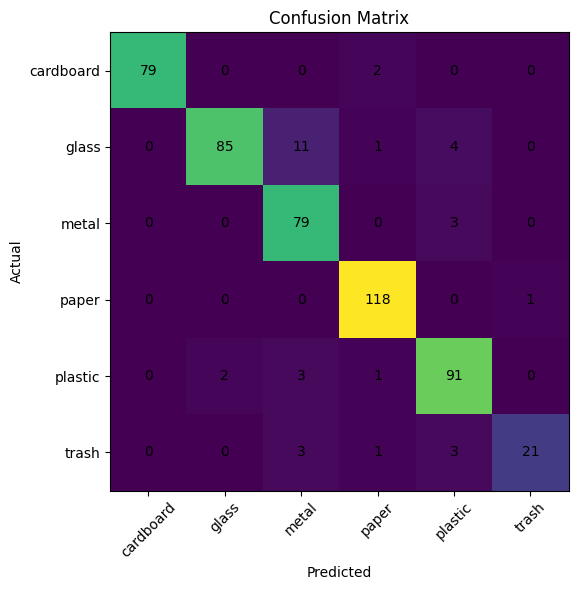

In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,6))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(np.arange(NUM_CLASSES), class_names, rotation=45)
plt.yticks(np.arange(NUM_CLASSES), class_names)

for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

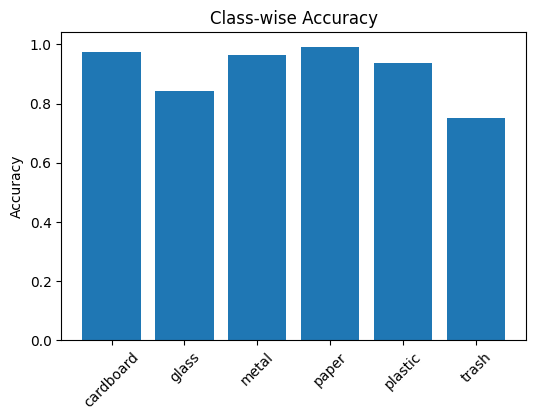

In [ ]:
class_acc = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(6,4))
plt.bar(class_names, class_acc)
plt.title("Class-wise Accuracy")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()

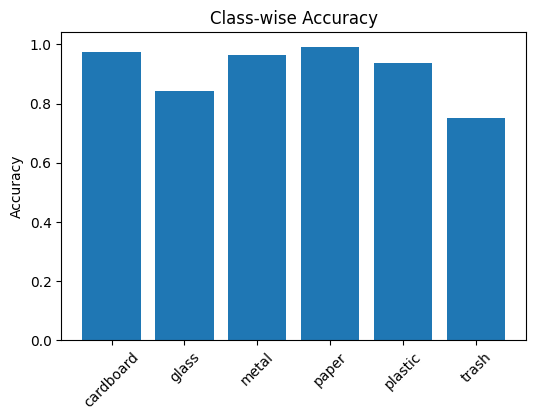

In [ ]:
class_acc = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(6,4))
plt.bar(class_names, class_acc)
plt.title("Class-wise Accuracy")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()

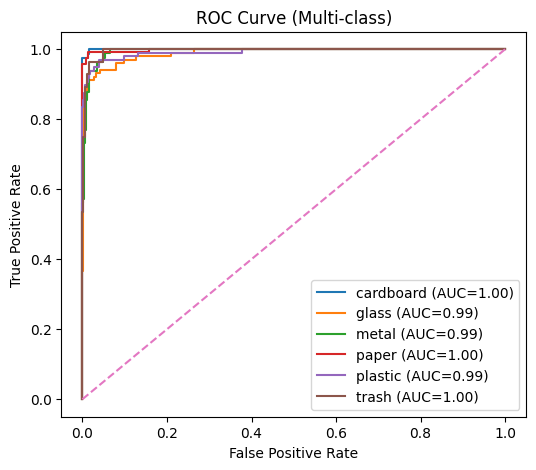

In [ ]:
binary_labels = label_binarize(all_labels, classes=range(NUM_CLASSES))

plt.figure(figsize=(6,5))

for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(binary_labels[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multi-class)")
plt.legend()
plt.show()

In [ ]:
with open("evaluation_metrics.txt","w") as f:
    f.write(f"Accuracy: {accuracy}\n")
    f.write(f"Precision: {precision}\n")
    f.write(f"Recall: {recall}\n")
    f.write(f"F1 Score: {f1}\n")

print("Metrics saved to evaluation_metrics.txt")

Metrics saved to evaluation_metrics.txt


In [ ]:
"""
MobileNetV2 Training Script for Kria KV260 Deployment
Updated with modern PyTorch quantization API (PyTorch 2.0+)

Implements best practices for edge AI deployment including:
- Post-Training Quantization (PTQ) - simpler and more compatible
- Model optimization for DPU
- ONNX export
- Comprehensive evaluation
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.models import MobileNet_V2_Weights
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Training configuration optimized for Kria KV260"""

    # Data settings
    DATA_DIR = "./data"  # Update this to your dataset path
    BATCH_SIZE = 32
    NUM_WORKERS = 4
    TRAIN_SPLIT = 0.8
    VAL_SPLIT = 0.1
    TEST_SPLIT = 0.1

    # Model settings - Kria KV260 optimization
    INPUT_SIZE = 224  # Standard MobileNetV2 input
    NUM_CLASSES = 2  # Binary classification (update for your use case)
    PRETRAINED = True

    # Training settings
    NUM_EPOCHS = 50
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 1e-4
    EARLY_STOPPING_PATIENCE = 7

    # Quantization settings for Kria KV260 DPU
    # Using Post-Training Quantization (PTQ) instead of QAT for better compatibility
    QUANTIZE = True

    # Export settings
    EXPORT_ONNX = True
    ONNX_OPSET = 11  # Compatible with most deployment tools

    # Output settings
    OUTPUT_DIR = "./outputs"
    CHECKPOINT_DIR = "./checkpoints"

    # Device
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================================
# DATA PREPARATION
# ============================================================================

def get_data_transforms():
    """
    Define data augmentation and normalization for MobileNetV2
    Uses ImageNet statistics for transfer learning
    """
    train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(Config.INPUT_SIZE),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    val_test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(Config.INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_test_transform

def prepare_dataloaders():
    """Prepare train, validation, and test dataloaders"""

    train_transform, val_test_transform = get_data_transforms()

    # Load full dataset
    full_dataset = datasets.ImageFolder(root=Config.DATA_DIR)

    # Calculate split sizes
    total_size = len(full_dataset)
    train_size = int(Config.TRAIN_SPLIT * total_size)
    val_size = int(Config.VAL_SPLIT * total_size)
    test_size = total_size - train_size - val_size

    # Split dataset
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # Apply transforms
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_test_transform
    test_dataset.dataset.transform = val_test_transform

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        num_workers=Config.NUM_WORKERS,
        pin_memory=True if torch.cuda.is_available() else False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=Config.NUM_WORKERS,
        pin_memory=True if torch.cuda.is_available() else False
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=Config.NUM_WORKERS,
        pin_memory=True if torch.cuda.is_available() else False
    )

    print(f"Dataset splits - Train: {train_size}, Val: {val_size}, Test: {test_size}")
    print(f"Class names: {full_dataset.classes}")

    return train_loader, val_loader, test_loader, full_dataset.classes

# ============================================================================
# MODEL DEFINITION
# ============================================================================

def create_mobilenetv2_model(num_classes=Config.NUM_CLASSES, pretrained=Config.PRETRAINED):
    """
    Create MobileNetV2 model optimized for Kria KV260

    Key optimizations:
    - Uses pretrained weights for better convergence
    - Modifies classifier for custom number of classes
    - Adds dropout for regularization
    """
    if pretrained:
        model = models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
    else:
        model = models.mobilenet_v2(weights=None)

    # Modify the classifier for custom number of classes
    # MobileNetV2 has 1280 features before the classifier
    in_features = model.classifier[1].in_features

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features, num_classes)
    )

    return model

# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    pbar = tqdm(dataloader, desc="Training")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Update progress bar
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc, all_preds, all_labels

# ============================================================================
# POST-TRAINING QUANTIZATION (Simpler and more compatible than QAT)
# ============================================================================

def calibrate_model(model, dataloader, device, num_batches=100):
    """
    Calibrate model for quantization using sample data
    This is used for Post-Training Quantization (PTQ)
    """
    model.eval()
    with torch.no_grad():
        for i, (inputs, _) in enumerate(tqdm(dataloader, desc="Calibrating")):
            if i >= num_batches:
                break
            inputs = inputs.to(device)
            model(inputs)

def quantize_model_ptq(model, val_loader, device):
    """
    Apply Post-Training Quantization (PTQ)
    More reliable than QAT for deployment to Kria KV260
    """
    print("\n🔧 Applying Post-Training Quantization...")

    # Move model to CPU for quantization
    model = model.cpu()
    model.eval()

    # Set quantization configuration
    model.qconfig = torch.quantization.get_default_qconfig('fbgemm')

    # Prepare for quantization (inserts observers)
    model_prepared = torch.quantization.prepare(model, inplace=False)

    # Calibrate with representative data
    calibrate_model(model_prepared, val_loader, torch.device('cpu'), num_batches=50)

    # Convert to quantized model
    model_quantized = torch.quantization.convert(model_prepared, inplace=False)

    print("✓ Post-Training Quantization completed")

    return model_quantized

# ============================================================================
# MAIN TRAINING LOOP
# ============================================================================

def train_model():
    """Main training function with all best practices"""

    # Create output directories
    os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
    os.makedirs(Config.CHECKPOINT_DIR, exist_ok=True)

    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.backends.cudnn.deterministic = True

    print("="*70)
    print("MobileNetV2 Training for Kria KV260 Deployment")
    print("="*70)
    print(f"Device: {Config.DEVICE}")
    print(f"Quantization: {'PTQ (Post-Training)' if Config.QUANTIZE else 'Disabled'}")
    print("="*70)

    # Prepare data
    print("\nPreparing data...")
    train_loader, val_loader, test_loader, class_names = prepare_dataloaders()

    # Create model
    print("\nCreating model...")
    model = create_mobilenetv2_model(num_classes=Config.NUM_CLASSES)
    model = model.to(Config.DEVICE)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                          lr=Config.LEARNING_RATE,
                          weight_decay=Config.WEIGHT_DECAY)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )

    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_val_acc = 0.0
    early_stopping_counter = 0

    print("\n" + "="*70)
    print("Starting Training...")
    print("="*70 + "\n")

    # Training loop
    for epoch in range(Config.NUM_EPOCHS):
        print(f"\nEpoch {epoch + 1}/{Config.NUM_EPOCHS}")
        print("-" * 50)

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, Config.DEVICE)

        # Validate
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, Config.DEVICE)

        # Update scheduler
        scheduler.step(val_loss)

        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print epoch results
        print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stopping_counter = 0
            checkpoint_path = os.path.join(Config.CHECKPOINT_DIR, 'best_model.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss,
            }, checkpoint_path)
            print(f"✓ Best model saved (Val Acc: {val_acc:.4f})")
        else:
            early_stopping_counter += 1

        # Early stopping
        if early_stopping_counter >= Config.EARLY_STOPPING_PATIENCE:
            print(f"\n⚠ Early stopping triggered after {epoch + 1} epochs")
            break

    print("\n" + "="*70)
    print("Training Completed!")
    print("="*70)

    # Load best model
    print("\nLoading best model...")
    checkpoint = torch.load(os.path.join(Config.CHECKPOINT_DIR, 'best_model.pth'))
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✓ Best model loaded (Val Acc: {checkpoint['val_acc']:.4f})")

    # Apply quantization if enabled
    model_quantized = None
    if Config.QUANTIZE:
        model_quantized = quantize_model_ptq(model, val_loader, Config.DEVICE)

    return model, model_quantized, history, class_names, test_loader

# ============================================================================
# EVALUATION
# ============================================================================

def evaluate_model(model, test_loader, class_names, model_name="Model"):
    """Comprehensive model evaluation"""

    print("\n" + "="*70)
    print(f"Evaluating {model_name} on Test Set...")
    print("="*70 + "\n")

    device = next(model.parameters()).device if hasattr(model, 'parameters') else torch.device('cpu')
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            # Handle quantized models (output may be different type)
            if isinstance(outputs, torch.Tensor):
                probs = torch.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, 1)
            else:
                # For quantized models, convert to tensor
                outputs_tensor = torch.from_numpy(outputs) if isinstance(outputs, np.ndarray) else outputs
                probs = torch.softmax(outputs_tensor, dim=1)
                _, preds = torch.max(outputs_tensor, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Print metrics
    print("\n📊 Test Set Metrics:")
    print("-" * 50)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    metrics = {
        'model': model_name,
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'confusion_matrix': conf_matrix.tolist(),
        'class_names': class_names
    }

    return metrics, conf_matrix

# ============================================================================
# MODEL EXPORT (for Kria KV260)
# ============================================================================

def export_model(model, model_quantized, class_names):
    """Export model for Kria KV260 deployment"""

    print("\n" + "="*70)
    print("Exporting Model for Deployment...")
    print("="*70 + "\n")

    model.eval()
    model = model.cpu()

    # 1. Save PyTorch model (FP32)
    pytorch_path = os.path.join(Config.OUTPUT_DIR, 'mobilenetv2_fp32.pth')
    torch.save(model.state_dict(), pytorch_path)
    print(f"✓ FP32 PyTorch model saved to {pytorch_path}")

    # 2. Save quantized model if available
    if model_quantized is not None:
        quant_path = os.path.join(Config.OUTPUT_DIR, 'mobilenetv2_int8.pth')
        torch.save(model_quantized.state_dict(), quant_path)
        print(f"✓ INT8 Quantized model saved to {quant_path}")

    # 3. Export to ONNX (for Vitis AI deployment on Kria)
    if Config.EXPORT_ONNX:
        dummy_input = torch.randn(1, 3, Config.INPUT_SIZE, Config.INPUT_SIZE)
        onnx_path = os.path.join(Config.OUTPUT_DIR, 'mobilenetv2_model.onnx')

        try:
            torch.onnx.export(
                model,
                dummy_input,
                onnx_path,
                export_params=True,
                opset_version=Config.ONNX_OPSET,
                do_constant_folding=True,
                input_names=['input'],
                output_names=['output'],
                dynamic_axes={
                    'input': {0: 'batch_size'},
                    'output': {0: 'batch_size'}
                }
            )
            print(f"✓ ONNX model saved to {onnx_path}")

            # Verify ONNX model
            try:
                import onnx
                onnx_model = onnx.load(onnx_path)
                onnx.checker.check_model(onnx_model)
                print("✓ ONNX model verification passed")
            except ImportError:
                print("⚠ ONNX not installed, skipping verification")
            except Exception as e:
                print(f"⚠ ONNX verification warning: {e}")
        except Exception as e:
            print(f"⚠ ONNX export failed: {e}")

    # 4. Save model metadata
    metadata = {
        'model_name': 'MobileNetV2',
        'input_size': Config.INPUT_SIZE,
        'num_classes': Config.NUM_CLASSES,
        'class_names': class_names,
        'quantized': Config.QUANTIZE,
        'quantization_type': 'PTQ' if Config.QUANTIZE else 'None',
        'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'preprocessing': {
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225]
        },
        'framework': 'PyTorch',
        'pytorch_version': torch.__version__
    }

    metadata_path = os.path.join(Config.OUTPUT_DIR, 'model_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)
    print(f"✓ Model metadata saved to {metadata_path}")

    # 5. Create deployment guide
    deployment_guide = f"""
# MobileNetV2 Deployment Guide for Kria KV260

## Model Information
- Architecture: MobileNetV2
- Input Size: {Config.INPUT_SIZE}x{Config.INPUT_SIZE}
- Number of Classes: {Config.NUM_CLASSES}
- Classes: {', '.join(class_names)}
- Quantization: {'PTQ (INT8)' if Config.QUANTIZE else 'FP32 only'}

## Files Generated
1. mobilenetv2_fp32.pth - PyTorch FP32 model weights
2. mobilenetv2_int8.pth - PyTorch INT8 quantized model (if enabled)
3. mobilenetv2_model.onnx - ONNX format for Vitis AI
4. model_metadata.json - Model configuration
5. test_metrics.json - Performance metrics

## Preprocessing Requirements
Images must be preprocessed with:
- Resize to 256x256
- Center crop to {Config.INPUT_SIZE}x{Config.INPUT_SIZE}
- Normalize with mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]

## Deployment Steps for Kria KV260

### Method 1: Using Vitis AI (Recommended)

#### Step 1: Quantize ONNX Model
```bash
# On development machine with Vitis AI Docker
./docker_run.sh xilinx/vitis-ai-pytorch:latest

# Inside container
vai_q_pytorch \\
  --model mobilenetv2_model.onnx \\
  --quant_mode calib \\
  --output_dir quantized/
```

#### Step 2: Compile for DPU
```bash
vai_c_xir \\
  --xmodel quantized/mobilenetv2_int.xmodel \\
  --arch /opt/vitis_ai/compiler/arch/DPUCZDX8G/KV260/arch.json \\
  --output_dir compiled/
```

#### Step 3: Deploy on Kria KV260
```python
import vart
import numpy as np
from PIL import Image

# Load DPU runner
dpu = vart.Runner.create_runner("mobilenetv2.xmodel", "run")

# Preprocess image
img = Image.open("test.jpg").resize(({Config.INPUT_SIZE}, {Config.INPUT_SIZE}))
img = np.array(img).astype(np.float32) / 255.0
img = (img - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
img = np.expand_dims(img.transpose(2, 0, 1), 0)

# Run inference
output = dpu.execute_async([img])[0]
prediction = np.argmax(output)
```

### Method 2: Using PyTorch on Kria (No DPU)

If deploying without DPU acceleration:

```python
import torch
from torchvision import transforms
from PIL import Image

# Load model
model = mobilenet_v2(num_classes={Config.NUM_CLASSES})
model.load_state_dict(torch.load('mobilenetv2_fp32.pth'))
model.eval()

# Preprocessing
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop({Config.INPUT_SIZE}),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Inference
img = Image.open("test.jpg")
input_tensor = transform(img).unsqueeze(0)
with torch.no_grad():
    output = model(input_tensor)
    prediction = output.argmax(1).item()
```

## Expected Performance

### FP32 Model
- Accuracy: See test_metrics_fp32.json
- CPU Inference: ~50-100ms per image
- Memory: ~14MB

### INT8 Quantized Model (with DPU)
- Accuracy: See test_metrics_int8.json (typically 0.5-1% drop from FP32)
- DPU Inference: ~15-30ms per image
- Throughput: ~30-60 FPS
- Memory: ~3.5MB

## Troubleshooting

### ONNX Export Issues
- Ensure PyTorch >= 2.0
- Try reducing opset version if needed
- Check for custom layers

### Quantization Accuracy Drop
- Increase calibration batches
- Use more representative calibration data
- Consider fine-tuning after quantization

### DPU Compilation Errors
- Verify arch.json matches your Kria version
- Check ONNX model compatibility
- Ensure all operations are DPU-supported

Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

    guide_path = os.path.join(Config.OUTPUT_DIR, 'DEPLOYMENT_GUIDE.md')
    with open(guide_path, 'w') as f:
        f.write(deployment_guide)
    print(f"✓ Deployment guide saved to {guide_path}")

# ============================================================================
# VISUALIZATION
# ============================================================================

def plot_training_history(history):
    """Plot training and validation metrics"""

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    axes[0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
    axes[0].plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # Plot accuracy
    axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o', linewidth=2)
    axes[1].plot(history['val_acc'], label='Val Accuracy', marker='s', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()

    plot_path = os.path.join(Config.OUTPUT_DIR, 'training_history.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"✓ Training history plot saved to {plot_path}")
    plt.close()

def plot_confusion_matrix(conf_matrix, class_names, model_name="Model"):
    """Plot confusion matrix"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    filename = f'confusion_matrix_{model_name.lower().replace(" ", "_")}.png'
    cm_path = os.path.join(Config.OUTPUT_DIR, filename)
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    print(f"✓ Confusion matrix saved to {cm_path}")
    plt.close()

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main execution function"""

    try:
        # Train model
        model, model_quantized, history, class_names, test_loader = train_model()

        # Plot training history
        plot_training_history(history)

        # Evaluate FP32 model
        metrics_fp32, cm_fp32 = evaluate_model(model.to(Config.DEVICE), test_loader, class_names, "FP32 Model")
        plot_confusion_matrix(cm_fp32, class_names, "FP32 Model")

        # Save FP32 metrics
        with open(os.path.join(Config.OUTPUT_DIR, 'test_metrics_fp32.json'), 'w') as f:
            json.dump(metrics_fp32, f, indent=4)

        # Evaluate quantized model if available
        if model_quantized is not None:
            metrics_int8, cm_int8 = evaluate_model(model_quantized, test_loader, class_names, "INT8 Quantized")
            plot_confusion_matrix(cm_int8, class_names, "INT8 Quantized")

            # Save INT8 metrics
            with open(os.path.join(Config.OUTPUT_DIR, 'test_metrics_int8.json'), 'w') as f:
                json.dump(metrics_int8, f, indent=4)

            # Compare metrics
            print("\n" + "="*70)
            print("Model Comparison")
            print("="*70)
            print(f"FP32 Accuracy:  {metrics_fp32['accuracy']:.4f}")
            print(f"INT8 Accuracy:  {metrics_int8['accuracy']:.4f}")
            print(f"Accuracy Drop:  {(metrics_fp32['accuracy'] - metrics_int8['accuracy']):.4f}")
            print("="*70)

        # Export models
        export_model(model, model_quantized, class_names)

        print("\n" + "="*70)
        print("✓ Pipeline Completed Successfully!")
        print("="*70)
        print(f"\nAll outputs saved to: {Config.OUTPUT_DIR}")
        print(f"Model checkpoints saved to: {Config.CHECKPOINT_DIR}")
        print("\nNext steps:")
        print("1. Review test_metrics_*.json for model performance")
        print("2. Check DEPLOYMENT_GUIDE.md for Kria KV260 deployment")
        print("3. Use Vitis AI to compile the ONNX model for DPU")
        if model_quantized:
            print("4. Compare FP32 vs INT8 performance trade-offs")
        print("="*70 + "\n")

    except Exception as e:
        print(f"\n❌ Error occurred: {e}")
        import traceback
        traceback.print_exc()
        print("\nTroubleshooting tips:")
        print("- Check if DATA_DIR path is correct")
        print("- Verify dataset has at least 2 classes")
        print("- Ensure sufficient GPU memory (reduce BATCH_SIZE if needed)")
        print("- Check all required packages are installed")

if __name__ == "__main__":
    main()

MobileNetV2 Training for Kria KV260 Deployment
Device: cuda
Quantization: PTQ (Post-Training)

Preparing data...

❌ Error occurred: [Errno 2] No such file or directory: './data'

Troubleshooting tips:
- Check if DATA_DIR path is correct
- Verify dataset has at least 2 classes
- Ensure sufficient GPU memory (reduce BATCH_SIZE if needed)
- Check all required packages are installed


Traceback (most recent call last):
  File "/tmp/ipython-input-2860976906.py", line 763, in main
    model, model_quantized, history, class_names, test_loader = train_model()
                                                                ^^^^^^^^^^^^^
  File "/tmp/ipython-input-2860976906.py", line 320, in train_model
    train_loader, val_loader, test_loader, class_names = prepare_dataloaders()
                                                         ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2860976906.py", line 106, in prepare_dataloaders
    full_dataset = datasets.ImageFolder(root=Config.DATA_DIR)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torchvision/datasets/folder.py", line 328, in __init__
    super().__init__(
  File "/usr/local/lib/python3.12/dist-packages/torchvision/datasets/folder.py", line 149, in __init__
    classes, class_to_idx = self.find_classes(self.root)
                            ^^^^^^^^^

In [ ]:
# Step 0: Install PyTorch and onnxscript if needed
!pip install torch --quiet
!pip install onnxscript --quiet

# Step 1: Import libraries
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import MobileNet_V2_Weights
from google.colab import files

# Step 2: Upload your .pth file
print("📤 Upload your .pth file")
uploaded = files.upload()  # Choose your .pth file

# Get uploaded filename
pth_filename = list(uploaded.keys())[0]
print("Uploaded file:", pth_filename)

# Step 3: Define your model architecture (MobileNetV2)
# Use the same architecture definition as during training
def create_mobilenetv2_model(num_classes, pretrained=True):
    if pretrained:
        model = models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
    else:
        model = models.mobilenet_v2(weights=None)

    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features, num_classes)
    )
    return model

# Step 4: Load checkpoint
checkpoint = torch.load(pth_filename, map_location="cpu")

# Extract necessary information from the checkpoint
# Based on previous cells, the checkpoint contains 'model_state_dict', 'class_names', 'input_size'
num_classes = len(checkpoint['class_names']) if 'class_names' in checkpoint else 6 # Default to 6 if not found
input_size = checkpoint['input_size'] if 'input_size' in checkpoint else 224 # Default to 224 if not found

model = create_mobilenetv2_model(num_classes=num_classes, pretrained=False) # No need for pretrained weights when loading state_dict
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("✅ Model loaded successfully")

# Step 5: Create dummy input (match training input size)
dummy_input = torch.randn(1, 3, input_size, input_size) # MobileNetV2 expects 3 channels, e.g., 224x224

# Step 6: Export to ONNX
onnx_path = "model.onnx"
torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)
print(f"✅ ONNX model exported to {onnx_path}")

# Step 7: Download ONNX model
files.download(onnx_path)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 17.9 MB/s eta 0:00:00
📤 Upload your .pth file


Saving best_model.pth to best_model (2).pth
Uploaded file: best_model (2).pth
✅ Model loaded successfully


/tmp/ipython-input-547310851.py:53: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W0211 10:48:48.637000 3177 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 11 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features
W0211 10:48:49.465000 3177 torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'input' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0, sampling_ratio: 'int' = -1, ali

[torch.onnx] Obtain model graph for `MobileNetV2([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `MobileNetV2([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...


[torch.onnx] Translate the graph into ONNX... ✅


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 120, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 115, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/adapters/axes_input_to_attribute.h:65: adapt: Asserti

Applied 104 of general pattern rewrite rules.
✅ ONNX model exported to model.onnx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>